# Package import

In [1]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns

from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence
sns.set_style('whitegrid')

import matplotlib.font_manager as fm

# RegulonDB Data Processing

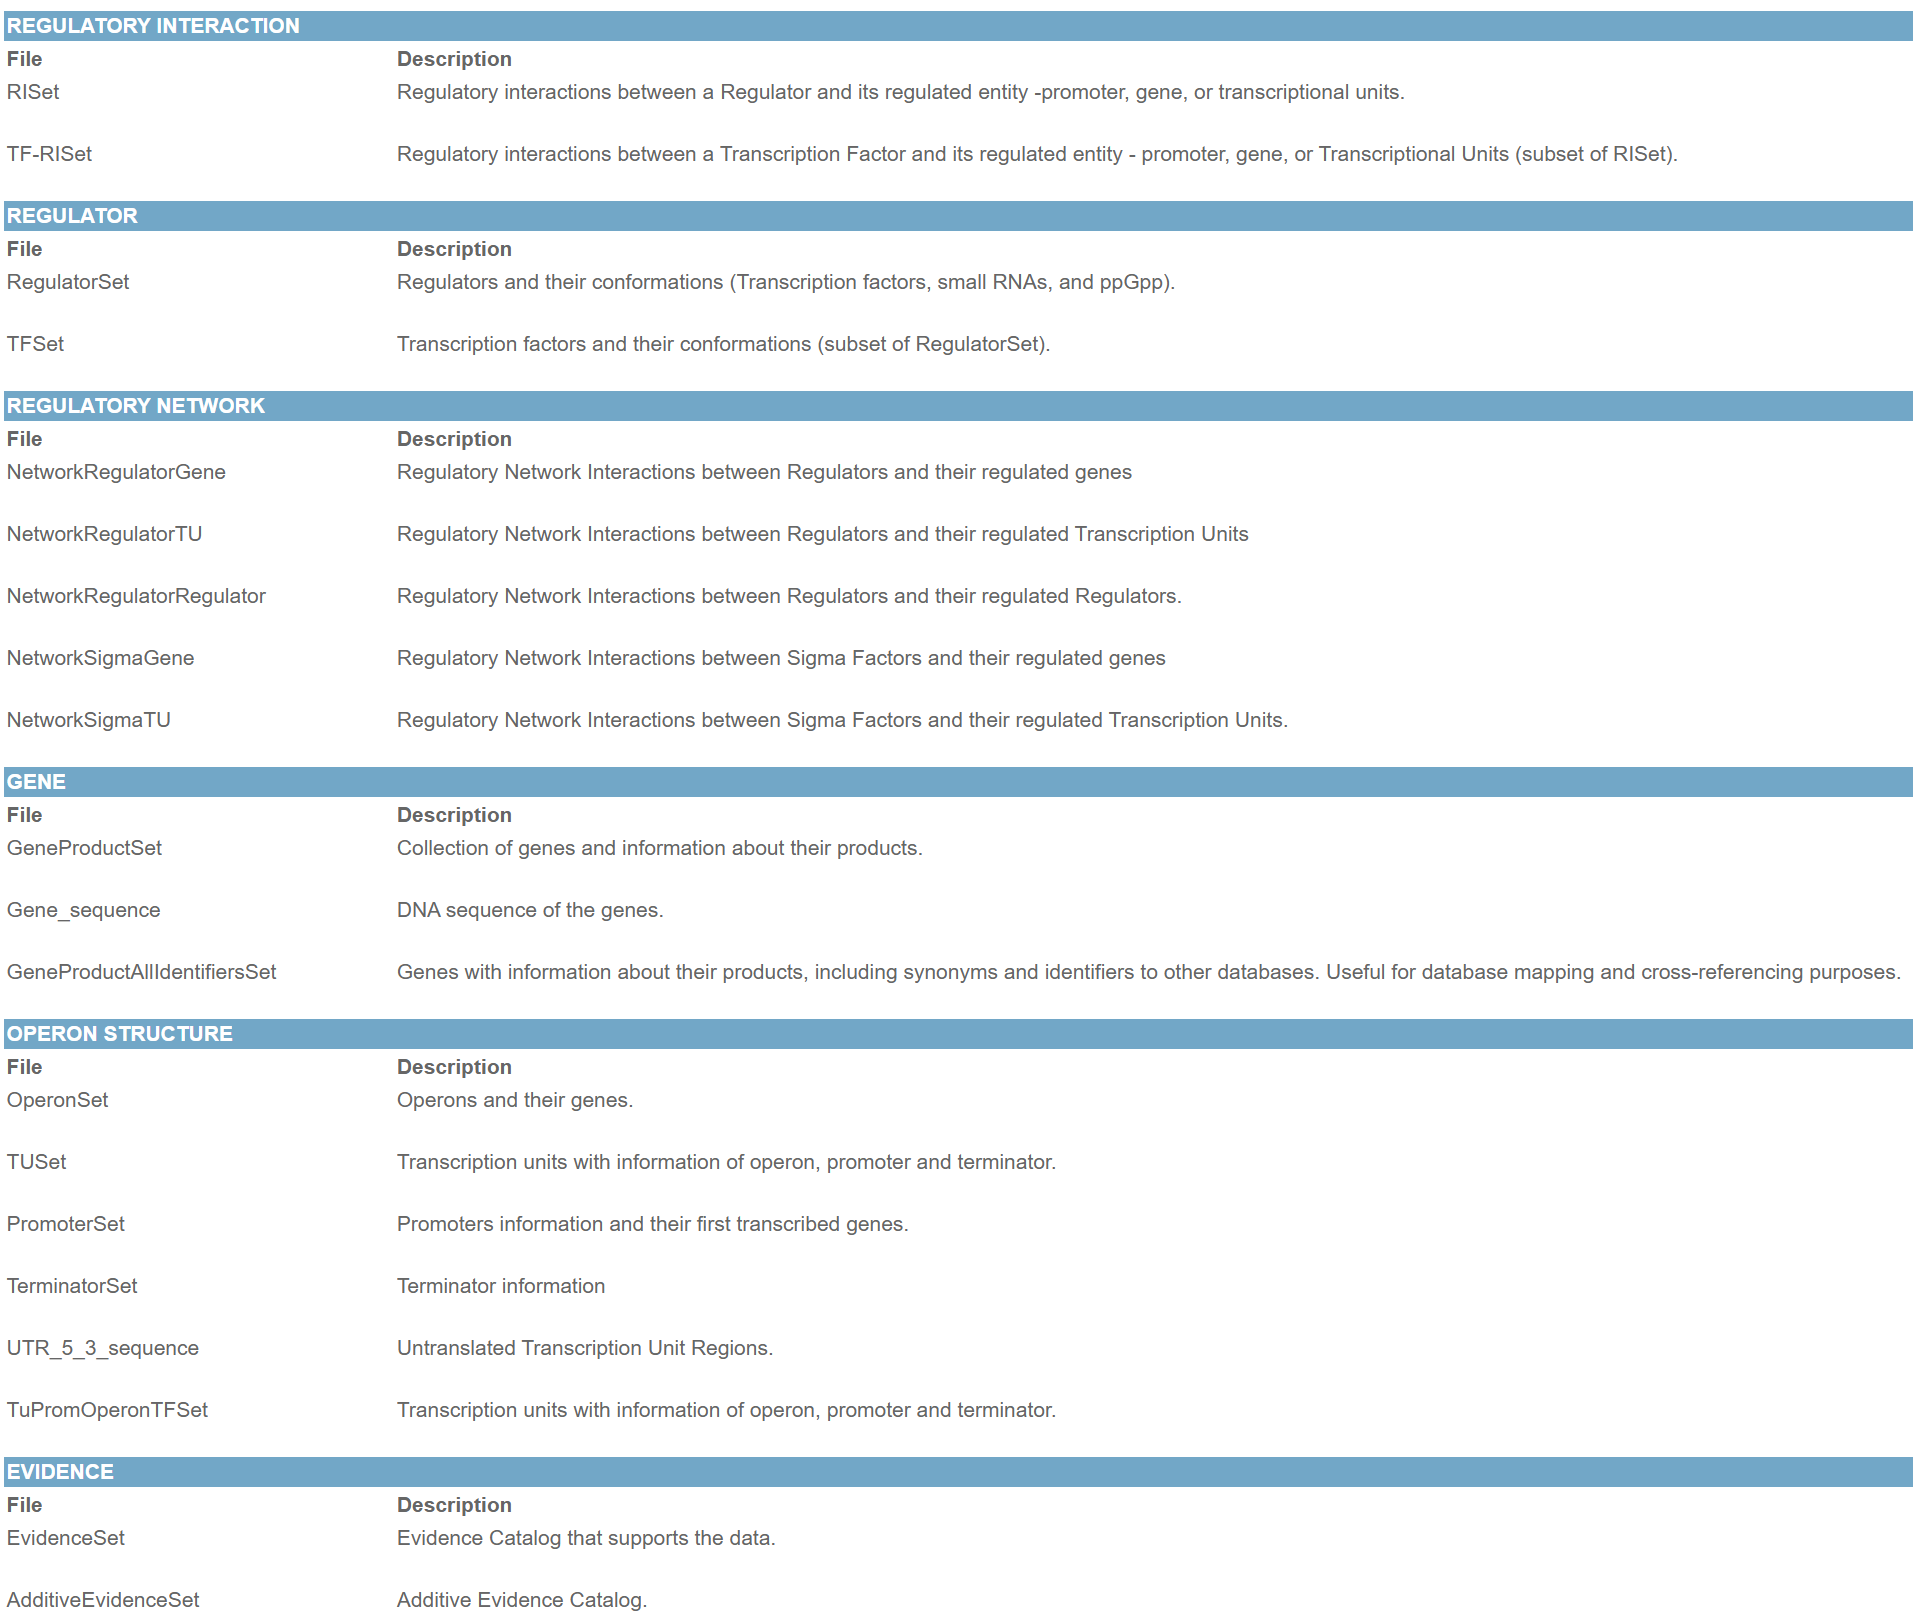

In [2]:
RegulonDB_Promoter_Set = pd.read_csv("../Data/RegulonDB_v13_08042024/PromoterSet.tsv", index_col=0, sep = '\t', comment='#')

# Precise1k and iModulon Data processing

## Load the data from ./Data/ folder

In [3]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [4]:
P1K_Gene_Presence_Matrix = pd.read_csv("../Data/P1K_Gene_Presence_Matrix.csv", index_col=0)

In [5]:
RegulonDB_TRN = pd.read_csv('../Data/RegulonDB_TRN_C_and_S.csv', index_col = 0)

In [6]:
biocyc_info = pd.read_csv('../Data/biocyc_info.txt', sep="\t")

### PRECISE-1K: X M A log_tpm gene_presence_matrix

In [7]:
P1K_M = precise1k.M

In [8]:
P1K_A = precise1k.A

In [9]:
P1K_X = precise1k.X

In [10]:
P1K_log_tpm = precise1k.log_tpm

In [11]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Identify rows with NaN 'Gene Name'
    removed_indices = merged_df[merged_df['Gene Name'].isna()]['Accession'].tolist()

    # Print the original indices that were removed
    print("Original indices removed due to NaN 'Gene Name':", removed_indices)

    # Set 'Gene Name' as the new index and drop the 'Accession' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

In [12]:
P1K_M = map_accession_to_gene_name(P1K_M, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [13]:
P1K_X = map_accession_to_gene_name(P1K_X, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [14]:
P1K_log_tpm = map_accession_to_gene_name(P1K_log_tpm, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [15]:
P1K_Gene_Presence_Matrix = map_accession_to_gene_name(P1K_Gene_Presence_Matrix, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


# Questions

## How many high confidence promoters are there in E. coli MG1655?

In [16]:
# Maybe need to cross-reference the genbank/regulonDB info with the Urtecho 2023 dataset

In [17]:
RegulonDB_Promoter_Set

,2)pmName,3)strand,4)posTSS,5)sigmaFactor,6)pmSequence,7)firstGeneName,8)distToFirstGene,9)pmEvidence,10)addEvidence,11)confidenceLevel,12)pmids
1)pmId,,,,,,,,,,,
RDBECOLIPMC00001,spyp,reverse,1825688.0,sigma70,acactttcattgttttaccgttgctctgattaattgacgctaaagt...,spy,-63.0,[COMP-AINF:W][COMP-HINF-POSITIONAL-IDENTIFICAT...,NaN,S,14529615;16861804;9068658
RDBECOLIPMC00002,yfeKp,forward,2537315.0,sigma24,ccgatgatcctcatcgtaatccaaccgaaactttacctgattctgg...,yfeK,-27.0,[COMP-AINF:W][COMP-AINF-POSITIONAL-IDENTIFICAT...,NaN,S,14529615;16336047
RDBECOLIPMC00003,bepAp1,forward,2616068.0,sigma24,gccgttacactcaaaggcggcgcggtgggaacgatatttcacagta...,bepA,-26.0,[COMP-AINF:W][COMP-AINF-POSITIONAL-IDENTIFICAT...,NaN,S,14529615;16336047;31992590
RDBECOLIPMC00004,bamBp,reverse,2638975.0,sigma24,aaatacttatggtgcgctggcttctttggaacttgcgcagcaattt...,bamB,-323.0,[COMP-AINF:W][COMP-AINF-POSITIONAL-IDENTIFICAT...,NaN,S,14529615;16336047
RDBECOLIPMC00005,recCp,reverse,2962507.0,sigma70,tgccaactggcaggtcaaccgaatgcagacatcgcaggcgggatgt...,recC,-79.0,[COMP-HINF-POSITIONAL-IDENTIFICATION:W][EXP-ID...,NaN,S,3520484
...,...,...,...,...,...,...,...,...,...,...,...
RDBECOLIPMC04051,stfZp1,reverse,105313.0,sigma70,accgccgccgccgccgacgccgatgactttaatcaccgcgtcattg...,stfZ,186.0,[EXP-IDA-TRANSCRIPTION-INIT-MAPPING-PRIMER-EXT...,NaN,W,36338044
RDBECOLIPMC04052,ameFp,forward,2911051.0,NaN,aggacaacagctggacgatgtccagcttgctcgctaccttttgtcg...,ameF,0.0,[EXP-IDA-TRANSCRIPTION-INIT-MAPPING:S][EXP-IMP:W],NaN,S,25266388;2911051;35012340
RDBECOLIPMC04053,oppAp2,forward,1300916.0,NaN,gcttaacaattttgcaaaatgtattggcgagtaagaaccgcatttg...,oppA,-266.0,[EXP-IDA-TRANSCRIPTION-INIT-MAPPING-PRIMER-EXT...,NaN,None,36860088


In [18]:
RegulonDB_Promoter_Set['11)confidenceLevel'].value_counts()

W       2517
S       1455
C         79
None       1
Name: 11)confidenceLevel, dtype: int64

> **Weak evidence (W)**: Single evidence with more ambiguous conclusions, where alternative explanations, indirect effects, or potential false positives are prevalent,
> 
    as well as computational predictions; for instance gel mobility shift assays with cell extracts or gene expression analysis.
> 
> **Strong evidence (S)**: Single evidence with direct physical interaction or solid genetic evidence with a low probability for alternative explanations;
> 
    for instance, footprinting with purified protein or site mutation.
> 
> **Confirmed (C)**: is assigned, if objects are supported by at least two independent types of strong evidence with mutually excluding false positives.
> 
    This approach is based essentially on the methods used to validate results and exclude alternative explanations in scientific research.

**S + C = 1455 + 79 = 1534**

## What does gene expression magnitude vs gene expression variation look like in P1k?

In [19]:
# Repeat of Cam's plot from the p1k study

In [20]:
P1K_merged = pd.read_csv('../Data/P1K_merged.csv', index_col=0)

In [21]:
P1K_merged

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm
thrA,0.899430,0.686194,thrA KO,0.076638,Cysteine-1,0.075628,Thiamine-1,3,3,0.708056,9.605329,11.771901,4.398331
thrB,0.808533,0.254512,thrA KO,0.227884,Leu/Val/Ile,0.103394,Leucine,1,2,0.698585,9.225274,7.560994,3.900854
thrC,0.824916,0.246587,thrA KO,0.234486,Leu/Val/Ile,0.155906,Dipeptide,1,1,0.612527,9.272277,7.647762,3.681351
yaaX,0.689923,0.171007,Leu/Val/Ile,0.169602,Nucleotide Stress,0.095365,Glycolate,0,3,0.737335,6.283661,11.817918,4.395201
yaaA,0.638300,0.428612,OxyR,0.171808,Cold Shock,0.129606,UC-8,0,1,0.306569,6.346626,8.667107,1.920613
...,...,...,...,...,...,...,...,...,...,...,...,...,...
yneP,0.748917,0.629455,yneP,0.075002,GadXW,0.047460,Resistance,0,1,1.059936,1.140369,4.458041,2.868327
ynfT,0.467147,0.424437,Cold Shock,0.045140,NRZ,0.033476,LPS,0,2,1.776698,2.466008,7.650393,6.189466
yoaL,0.333663,0.102746,CpxR,0.066571,Cellulose,0.044315,ppGpp,0,2,0.540346,5.048395,5.552991,2.841891
yqhI,0.894360,0.738529,yqhI,0.091457,UC-8,0.084815,Resistance,0,2,1.195671,1.195671,7.305199,4.985373


In [22]:
def scatter_plot_with_box_plots(dataframe, mad_column, median_column, x_label, y_label, title, ratio=0.2, x_lim=None, y_lim=None, color='blue'):
    # Set the aesthetic style of the plots
    sns.set(style="white")

    # Create the figure and axes
    fig = plt.figure(figsize=(4, 4))

    # Define grid spec with ratio adjustment
    height_ratios = [ratio, 1-ratio]  # ratio for the top subplot, remaining for the main plot
    width_ratios = [1-ratio, ratio]   # ratio for the main plot, remaining for the right subplot

    grid = plt.GridSpec(2, 2, height_ratios=height_ratios, width_ratios=width_ratios, hspace=0.05, wspace=0.05)

    # Main scatter plot
    main_ax = fig.add_subplot(grid[1, 0])
    main_ax.scatter(dataframe[median_column], dataframe[mad_column], color=color, alpha=0.5)
    main_ax.set_xlabel(x_label)
    main_ax.set_ylabel(y_label)
    main_ax.grid(False)
    main_ax.spines['top'].set_linewidth(1)
    main_ax.spines['right'].set_linewidth(1)
    main_ax.spines['bottom'].set_linewidth(1)
    main_ax.spines['left'].set_linewidth(1)
    main_ax.tick_params(top=False, right=False, which='both', labeltop=False, labelright=False)
    
    # Set the limits for the main scatter plot if provided
    if x_lim:
        main_ax.set_xlim(x_lim)
    if y_lim:
        main_ax.set_ylim(y_lim)

    # Box plot for the x-axis
    x_box = fig.add_subplot(grid[0, 0], sharex=main_ax)
    sns.boxplot(x=dataframe[median_column], ax=x_box, color=color)
    x_box.set(xlabel='')
    x_box.set(yticks=[], ylabel='')
    x_box.grid(False)
    x_box.spines['top'].set_linewidth(1)
    x_box.spines['right'].set_linewidth(1)
    x_box.spines['bottom'].set_linewidth(1)
    x_box.spines['left'].set_linewidth(1)
    x_box.tick_params(bottom=False, top=False, labelbottom=False)

    # Box plot for the y-axis
    y_box = fig.add_subplot(grid[1, 1], sharey=main_ax)
    sns.boxplot(y=dataframe[mad_column], ax=y_box, color=color)
    y_box.set(ylabel='')
    y_box.set(xticks=[], xlabel='')
    y_box.grid(False)
    y_box.spines['top'].set_linewidth(1)
    y_box.spines['right'].set_linewidth(1)
    y_box.spines['bottom'].set_linewidth(1)
    y_box.spines['left'].set_linewidth(1)
    y_box.tick_params(left=False, right=False, labelleft=False)

    # Add titles and labels
    x_box.set_title(title, y=1.1)

    # Show the plot
    plt.show()

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter_with_fit(X, A, gene_name, imodulon_name):
    # Extract the rows
    x_values = X.loc[gene_name].values.reshape(-1, 1)
    y_values = A.loc[imodulon_name].values
    
    plt.figure(figsize=(15, 2))
    # Create scatter plot
    plt.scatter(x_values, y_values, label='Data points')

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    
    # Plot the line of best fit
    plt.plot(x_values, y_pred, color='red', label='Line of best fit')

    # Calculate the R^2 value
    r2 = r2_score(y_values, y_pred)
    
    # Display the plot with labels and legend
    plt.xlabel(gene_name)
    plt.ylabel(imodulon_name)
    plt.title(f'Scatter Plot of {gene_name} Expression and {imodulon_name} Activity\n$R^2$ = {r2:.2f}')
    plt.legend()
    plt.show()

In [24]:
def calculate_explained_variance(M_matrix, A_matrix, log_tpm):
    # Check if inputs are DataFrames and convert to numpy arrays if needed
    if isinstance(M_matrix, pd.DataFrame) or isinstance(M_matrix, pd.Series):
        M_matrix = M_matrix.values.flatten()
    
    if isinstance(A_matrix, pd.DataFrame):
        A_matrix = A_matrix.values
    
    if isinstance(log_tpm, pd.DataFrame) or isinstance(log_tpm, pd.Series):
        log_tpm = log_tpm.values.flatten()
    
    # Compute the predicted values
    predicted_values = np.dot(M_matrix, A_matrix)  # M_matrix is 1xM, A_matrix is MxN, result is 1xN

    # Calculate the baseline (mean-centered log_tpm)
    baseline = log_tpm - np.mean(log_tpm)  # mean-center the log_tpm

    # Calculate the residual variance
    residuals = log_tpm - predicted_values
    residual_variance = np.sum((residuals - np.mean(residuals)) ** 2)

    # Calculate the total variance
    total_variance = np.sum((log_tpm - np.mean(log_tpm)) ** 2)

    # Compute the explained variance (R^2)
    explained_variance = 1 - (residual_variance / total_variance)
    
    return explained_variance

In [25]:
def compute_explained_variance_change(M, A, X, P1K_Gene_Presence_Matrix, gene):

    M = M.loc[[gene]]
    X = X.loc[[gene]]
    
    # Calculate the original explained variance
    original_exp_var = calculate_explained_variance(M, A, X)
    
    # Initialize a dictionary to store the explained variance changes
    exp_var_changes = {}

    # Iterate through each row of A
    for row_name in A.index:
        # Remove the corresponding row from A
        modified_A = A.drop(row_name, axis=0)
        
        # Remove the corresponding column from M and X
        modified_M = M.drop(row_name, axis=1)
        modified_X = X
        
        # Recalculate the explained variance
        new_exp_var = calculate_explained_variance(modified_M, modified_A, modified_X)
        
        # Calculate the change in explained variance
        exp_var_change = original_exp_var - new_exp_var
        
        # Store the result in the dictionary
        exp_var_changes[row_name] = exp_var_change

    # Convert the dictionary to a DataFrame
    explained_variance_df = pd.DataFrame.from_dict(exp_var_changes, orient='index', columns=['Explained Variance'])
    explained_variance_df.reset_index(inplace=True)

    
    explained_variance_df.columns = ['iModulon', 'Explained Variance Change if removed']

    explained_variance_df = explained_variance_df.sort_values(by='Explained Variance Change if removed', ascending=False)
    
    explained_variance_df['Presence'] = explained_variance_df['iModulon'].apply(
        lambda x: 'Yes' if P1K_Gene_Presence_Matrix.loc[gene, x] else 'No'
    )
    
    # Calculate and print the sum of Explained Variance for 'Presence Yes' and 'Presence No'
    presence_yes_sum = explained_variance_df[explained_variance_df['Presence'] == 'Yes']['Explained Variance Change if removed'].sum()
    presence_no_sum = explained_variance_df[explained_variance_df['Presence'] == 'No']['Explained Variance Change if removed'].sum()
    
    # print(f"Sum of Explained Variance for 'Yes' iMs: {presence_yes_sum}")
    # print(f"Sum of Explained Variance for 'No' iMs: {presence_no_sum}")
    
    # Load custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Plot the explained variance for each iModulon
    plt.figure(figsize=(15, 3))
    plt.bar(explained_variance_df['iModulon'], explained_variance_df['Explained Variance Change if removed'])
    plt.xlabel('iModulon', fontproperties=font_prop)
    plt.ylabel('Explained Variance', fontproperties=font_prop)
    plt.title(f'Explained Variance by iModulon for Gene {gene}', fontproperties=font_prop)
    
    # Remove grid
    plt.grid(False)
    
    # Add a black border around the plot
    plt.gca().spines['top'].set_linewidth(1.0)
    plt.gca().spines['bottom'].set_linewidth(1.0)
    plt.gca().spines['left'].set_linewidth(1.0)
    plt.gca().spines['right'].set_linewidth(1.0)
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['right'].set_color('black')

    # Set font properties for ticks
    plt.xticks(fontproperties=font_prop, fontsize=10)  # Adjust fontsize for x-ticks
    plt.yticks(fontproperties=font_prop)

    # Remove x-ticks
    plt.xticks([])

    plt.show()
    return explained_variance_df

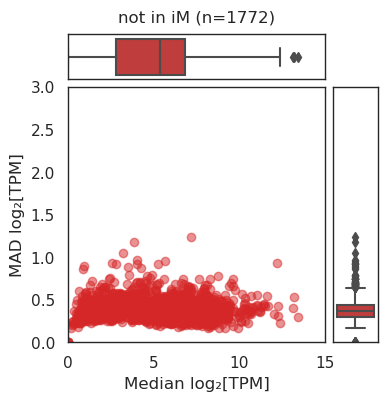

In [26]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'MAD', 'log_TPM_median', 'Median log₂[TPM]', 'MAD log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,15), y_lim=(0,3), color='#d62728')

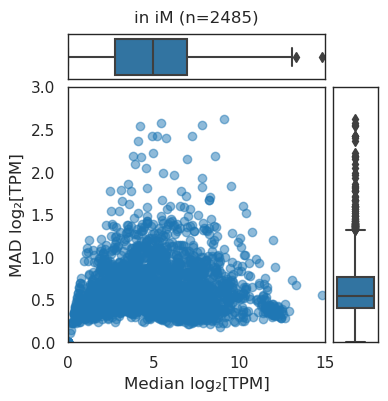

In [27]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'MAD', 'log_TPM_median', 'Median log₂[TPM]', 'MAD log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,15), y_lim=(0,3), color='#1f77b4')

In [28]:
P1K_merged.columns

Index(['Total_Explained_Variance', 'Top_1_Explained_Variance',
       'Top_1_iModulon', 'Top_2_Explained_Variance', 'Top_2_iModulon',
       'Top_3_Explained_Variance', 'Top_3_iModulon', 'num_regulators',
       'num_iM', 'MAD', 'log_TPM_median', 'range_log_tpm',
       'quantile_range_log_tpm'],
      dtype='object')

### MAD v.s. Total_Explained_Variance

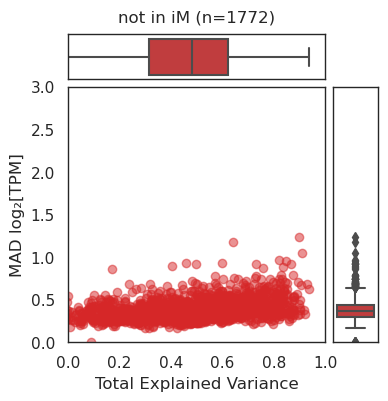

In [29]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'MAD', 'Total_Explained_Variance', 'Total Explained Variance', 'MAD log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(0,3), color='#d62728')

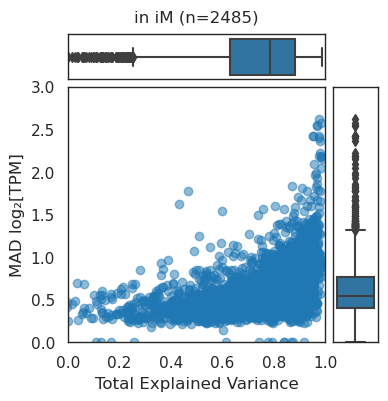

In [30]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'MAD', 'Total_Explained_Variance', 'Total Explained Variance', 'MAD log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(0,3), color='#1f77b4')

### MAD v.s. Top_1_Explained_Variance

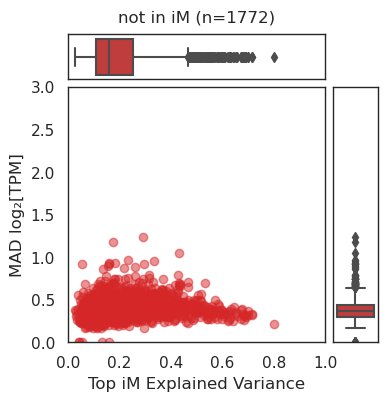

In [31]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'MAD', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'MAD log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(0,3), color='#d62728')

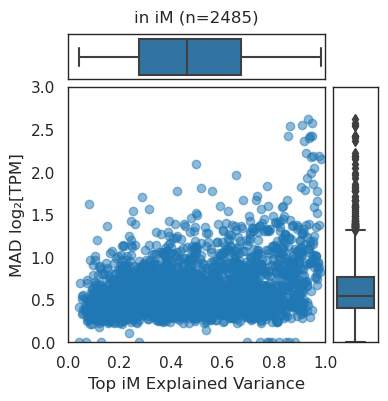

In [32]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'MAD', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'MAD log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(0,3), color='#1f77b4')

### Total_Explained_Variance v.s. Top_1_Explained_Variance

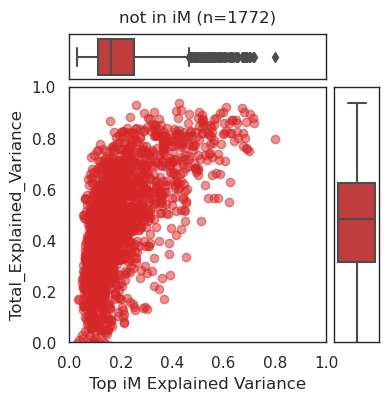

In [33]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'Total_Explained_Variance', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'Total_Explained_Variance', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(0,1), color='#d62728')

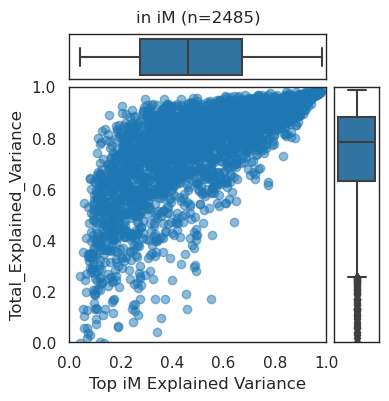

In [34]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'Total_Explained_Variance', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'Total_Explained_Variance', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(0,1), color='#1f77b4')

In [35]:
P1K_merged[(P1K_merged['Total_Explained_Variance'] < 0.1) & (P1K_merged['Top_1_Explained_Variance'] < 0.1)]

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm
mbiA,-0.111055,0.090604,UC-5,0.079584,DNA Damage,0.073846,UC-6,1,1,0.344671,0.594516,4.124902,1.753399
fixX,0.016148,0.070135,UC-2,0.036621,Efflux Pump,0.033455,LPS,2,1,0.452503,1.067281,4.073628,2.146699
yaaU,0.010478,0.036379,Translation,0.025086,FucR/AllR/AraC,0.023241,Leucine,1,0,0.265966,0.935804,3.759078,1.410842
hofC,-0.392463,0.043687,UC-1,0.038587,baeR KO,0.036615,nquinone ALE 3,2,0,0.249276,2.464637,3.432930,1.401694
dksA,-0.019715,0.071485,UC-8,0.046670,UC-7,0.041621,Flagella,0,0,0.292394,9.821839,9.380926,1.897957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ylbE,0.079831,0.073881,Efflux Pump,0.052618,gcvB,0.048600,Translation,0,0,0.345812,1.600979,3.765633,1.814542
ybfK,-0.136118,0.054935,yneP,0.028860,Phosphate-2,0.022051,SSW SNPs,0,0,0.000000,0.000000,3.348480,0.842443
ytcA,-0.360113,0.041261,RpoE,0.040898,UC-2,0.020968,PlaR,0,0,0.000000,0.000000,2.914991,1.049006
aaaD,-0.019719,0.060060,ppGpp,0.054926,Fnr-2,0.045857,UC-7,0,0,0.441638,1.146189,3.895771,2.215998


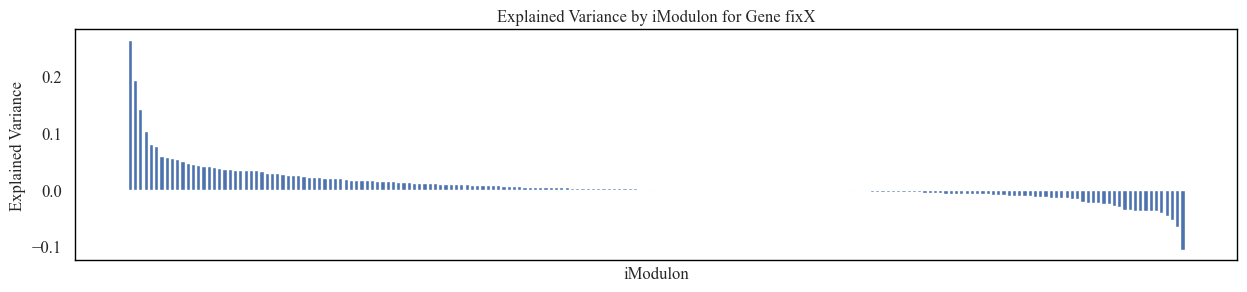

,iModulon,Explained Variance Change if removed,Presence
164,minicoli KOs,0.264344,No
92,Crp-1,0.193260,No
167,UC-2,0.141767,No
81,crp KO-1,0.103201,No
192,crp KO-2,0.080147,No
...,...,...,...
94,NtrC-1,-0.040070,No
74,ArcA,-0.046058,No
126,Thiamine-1,-0.053959,No
146,Glycolate,-0.065828,No


In [36]:
compute_explained_variance_change(P1K_M, P1K_A, P1K_X, P1K_Gene_Presence_Matrix, 'fixX')

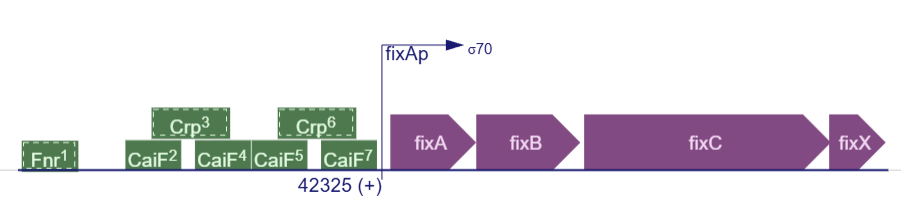

ydfW

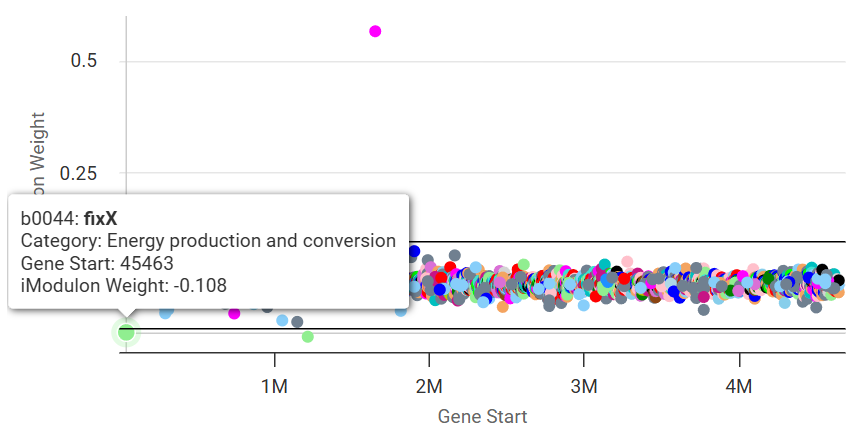

In [37]:
P1K_merged[(P1K_merged['Total_Explained_Variance'] < 0.1) & (P1K_merged['Top_1_Explained_Variance'] < 0.4)]

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm
yaaW,-0.197540,0.184582,Cold Shock,0.082831,Translation,0.062717,UC-6,0,0,0.360424,2.109164,4.097773,1.758149
mbiA,-0.111055,0.090604,UC-5,0.079584,DNA Damage,0.073846,UC-6,1,1,0.344671,0.594516,4.124902,1.753399
caiB,-0.060414,0.100315,Microaerobic,0.085382,Methionine,0.065316,Fnr-3,3,0,0.356151,2.850299,3.694327,1.883417
fixA,0.068155,0.158253,Tryptophanase,0.092234,UC-3,0.075987,LPS,2,0,0.362466,1.291711,4.795469,1.767795
fixX,0.016148,0.070135,UC-2,0.036621,Efflux Pump,0.033455,LPS,2,1,0.452503,1.067281,4.073628,2.146699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ybfK,-0.136118,0.054935,yneP,0.028860,Phosphate-2,0.022051,SSW SNPs,0,0,0.000000,0.000000,3.348480,0.842443
ytcA,-0.360113,0.041261,RpoE,0.040898,UC-2,0.020968,PlaR,0,0,0.000000,0.000000,2.914991,1.049006
aaaD,-0.019719,0.060060,ppGpp,0.054926,Fnr-2,0.045857,UC-7,0,0,0.441638,1.146189,3.895771,2.215998
ypjI,-0.127160,0.071093,SSW SNPs,0.040261,Glycine,0.021069,ydaG,0,0,0.363043,0.363043,3.609087,1.475925


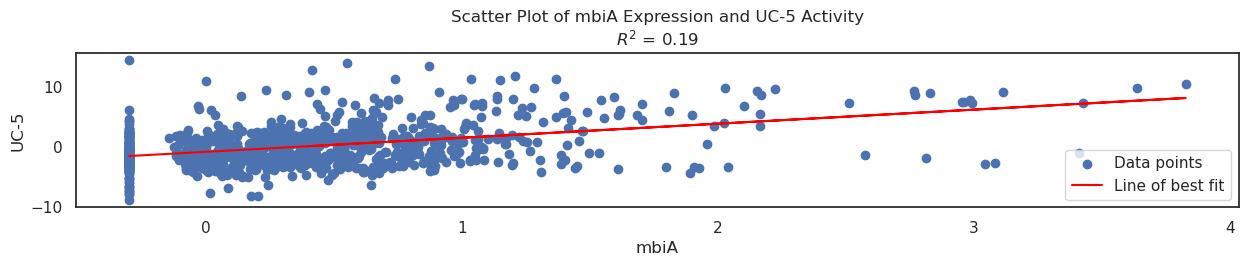

In [38]:
plot_scatter_with_fit(P1K_X, P1K_A, 'mbiA', 'UC-5')

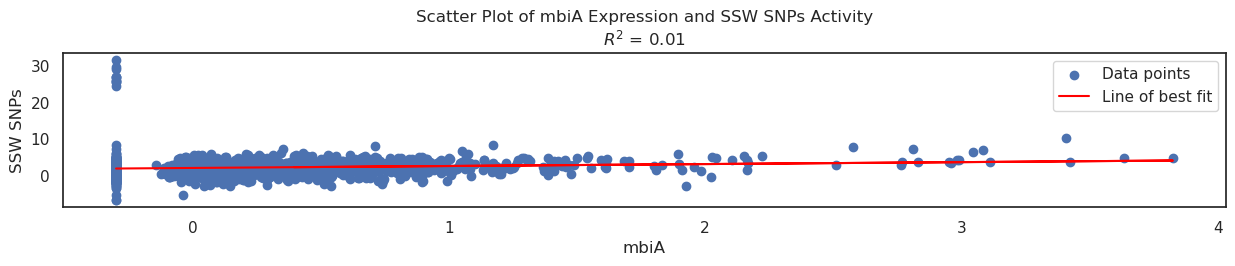

In [39]:
plot_scatter_with_fit(P1K_X, P1K_A, 'mbiA', 'SSW SNPs')

SSW SNPs

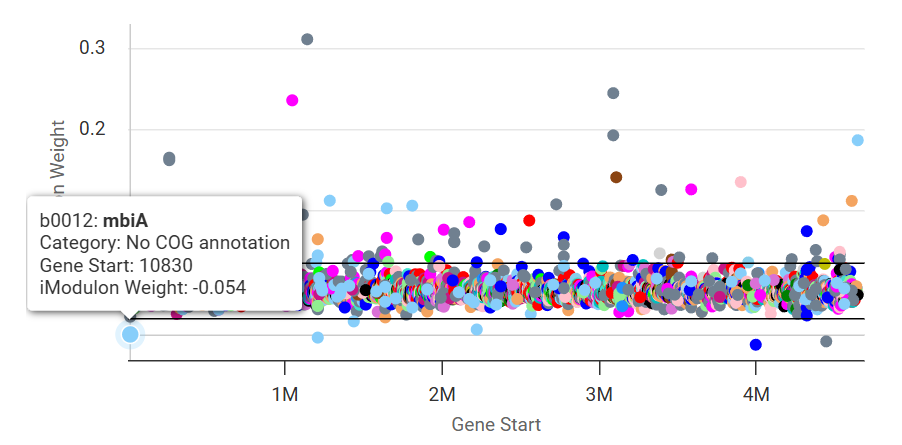

### Range v.s. Top_1_Explained_Variance

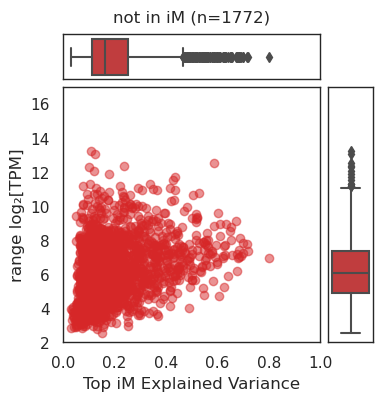

In [40]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'range_log_tpm', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'range log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(2,17), color='#d62728')

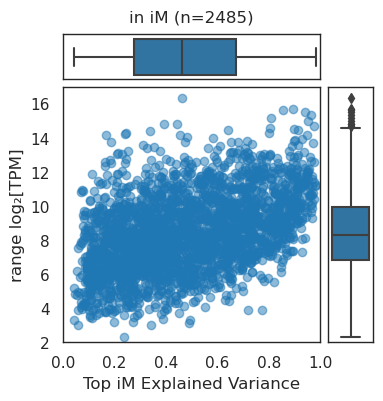

In [41]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'range_log_tpm', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'range log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(2,17), color='#1f77b4')

### Quantile Range v.s. Top_1_Explained_Variance

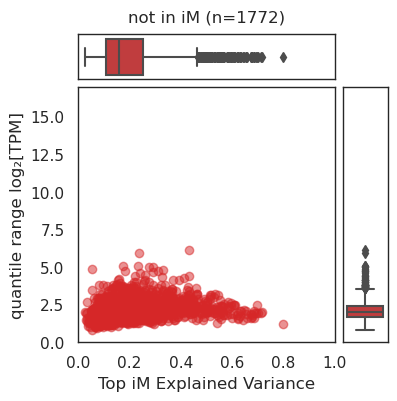

In [42]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'quantile_range_log_tpm', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'quantile range log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(0,17), color='#d62728')

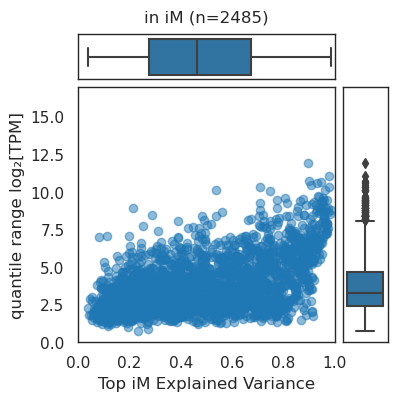

In [43]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'quantile_range_log_tpm', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'quantile range log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(0,17), color='#1f77b4')

### Range v.s. MAD

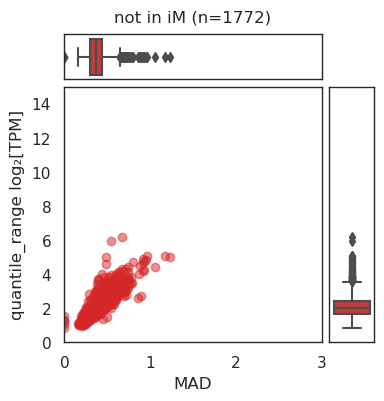

In [44]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'quantile_range_log_tpm', 'MAD', 'MAD', 'quantile_range log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,3), y_lim=(0,15), color='#d62728')

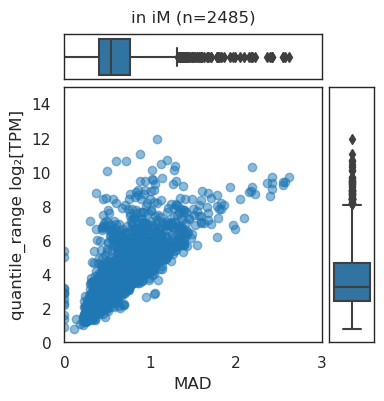

In [45]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'quantile_range_log_tpm', 'MAD', 'MAD', 'quantile_range log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,3), y_lim=(0,15), color='#1f77b4')

In [46]:
# rank the genes by the M values in iM - if they are close to threshold

In [47]:
# left bottom corner - examples - MAD 1.5 - <0.2 top exp var

## In each of the 9 expression categories, how many regulons and iMs does each gene participate in? 

In [48]:
# Categories are high expression high variance, medium expression high variance, and so on, with thresholds we'll have to try to determine by elbows

#### Threshold set to similar to Cam

In [49]:
from kneed import KneeLocator

mad_values = P1K_merged['MAD'].values

# Sort the MAD values
sorted_mad_values = sorted(mad_values)

# Find the elbow point
kneedle = KneeLocator(range(len(sorted_mad_values)), sorted_mad_values, curve='convex', direction='increasing')
elbow_point = kneedle.elbow

# Elbow value in terms of MAD
elbow_value = sorted_mad_values[elbow_point]

# Define thresholds
high_variance_threshold = elbow_value - 0.5
low_variance_threshold = elbow_value / 4 - 0.128

# Classify the genes
P1K_merged['Variance_Category'] = pd.cut(
    P1K_merged['MAD'],
    bins=[-np.inf, low_variance_threshold, high_variance_threshold, np.inf],
    labels=['Low Variance', 'Medium Variance', 'High Variance']
)

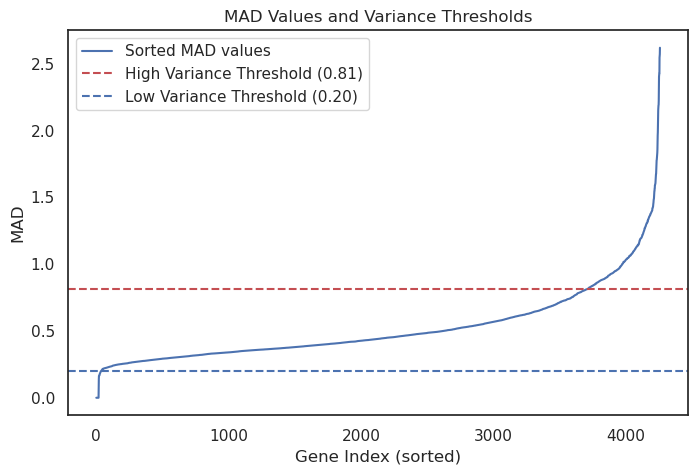

In [50]:
plt.figure(figsize=(8, 5))
plt.plot(sorted_mad_values, label='Sorted MAD values')

# Add high variance threshold
plt.axhline(y=high_variance_threshold, color='r', linestyle='--', label=f'High Variance Threshold ({high_variance_threshold:.2f})')

# Add low variance threshold
plt.axhline(y=low_variance_threshold, color='b', linestyle='--', label=f'Low Variance Threshold ({low_variance_threshold:.2f})')

# Add labels and title
plt.xlabel('Gene Index (sorted)')
plt.ylabel('MAD')
plt.title('MAD Values and Variance Thresholds')
plt.legend()

# Show the plot
plt.show()

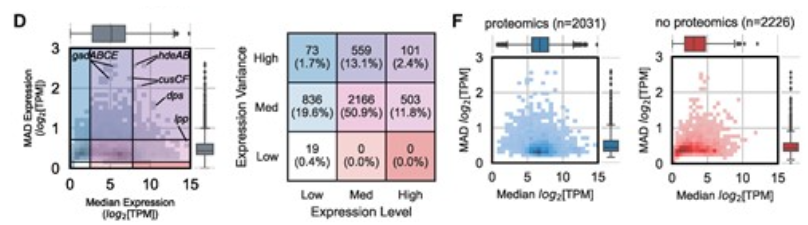

In [51]:
# Extract the log_TPM_median column
log_tpm_median_values = P1K_merged['log_TPM_median'].values

# Sort the log_TPM_median values
sorted_log_tpm_median_values = sorted(log_tpm_median_values)

# Find the elbow point
kneedle_tpm = KneeLocator(range(len(sorted_log_tpm_median_values)), sorted_log_tpm_median_values, curve='convex', direction='increasing')
elbow_point_tpm = kneedle_tpm.elbow

# Elbow value in terms of log_TPM_median
elbow_value_tpm = sorted_log_tpm_median_values[elbow_point_tpm]

# Define thresholds
high_expression_threshold = elbow_value_tpm - 2.5
low_expression_threshold = elbow_value_tpm / 3 - 0.8# This is arbitrary, adjust as needed

# Classify the genes
P1K_merged['Expression_Category'] = pd.cut(
    P1K_merged['log_TPM_median'],
    bins=[-np.inf, low_expression_threshold, high_expression_threshold, np.inf],
    labels=['Low Expression', 'Medium Expression', 'High Expression']
)

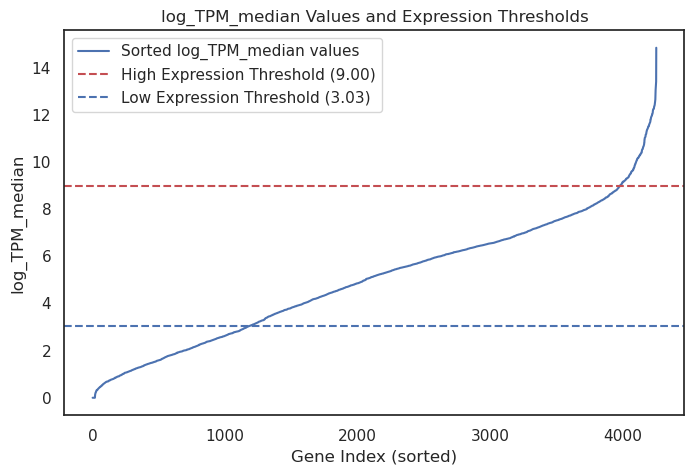

In [52]:
plt.figure(figsize=(8, 5))
plt.plot(sorted_log_tpm_median_values, label='Sorted log_TPM_median values')

# Add high expression threshold
plt.axhline(y=high_expression_threshold, color='r', linestyle='--', label=f'High Expression Threshold ({high_expression_threshold:.2f})')

# Add low expression threshold
plt.axhline(y=low_expression_threshold, color='b', linestyle='--', label=f'Low Expression Threshold ({low_expression_threshold:.2f})')

# Add labels and title
plt.xlabel('Gene Index (sorted)')
plt.ylabel('log_TPM_median')
plt.title('log_TPM_median Values and Expression Thresholds')
plt.legend()

# Show the plot
plt.show()

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_categorized_histogram(df, num_iM_col, var_cat_col, exp_cat_col, title, xlabel, ylabel):
    # Convert categorical columns to strings and create a new combined category
    df['Combined_Category'] = df[var_cat_col].astype(str) + ' - ' + df[exp_cat_col].astype(str)
    
    # Define a color palette with 9 distinct colors
    colors = {
        'High Variance - High Expression': 'red',
        'High Variance - Medium Expression': 'blue',
        'High Variance - Low Expression': 'green',
        'Medium Variance - High Expression': 'orange',
        'Medium Variance - Medium Expression': 'purple',
        'Medium Variance - Low Expression': 'brown',
        'Low Variance - High Expression': 'pink',
        'Low Variance - Medium Expression': 'gray',
        'Low Variance - Low Expression': 'yellow'
    }

    # Count the occurrences of each combined category for each num_iM
    category_counts = df.groupby([num_iM_col, 'Combined_Category']).size().unstack(fill_value=0)

    # Plot the histogram
    category_counts.plot(kind='bar', stacked=True, color=[colors[cat] for cat in category_counts.columns], figsize=(12, 6))

    # Set the title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)

    # Show the legend
    plt.legend(title='', loc='best')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Calculate percentages for Low, Medium, and High Variance categories
    variance_categories = ['Low Variance', 'Medium Variance', 'High Variance']
    percentage_df = pd.DataFrame(index=category_counts.index, columns=variance_categories, dtype=float)
    
    for variance in variance_categories:
        # Sum the sub-categories for each variance level
        variance_cols = [col for col in category_counts.columns if col.startswith(variance)]
        variance_sum = category_counts[variance_cols].sum(axis=1)
        # Calculate percentage
        total_counts = category_counts.sum(axis=1)
        percentage_df[variance] = (variance_sum / total_counts) * 100

    return percentage_df

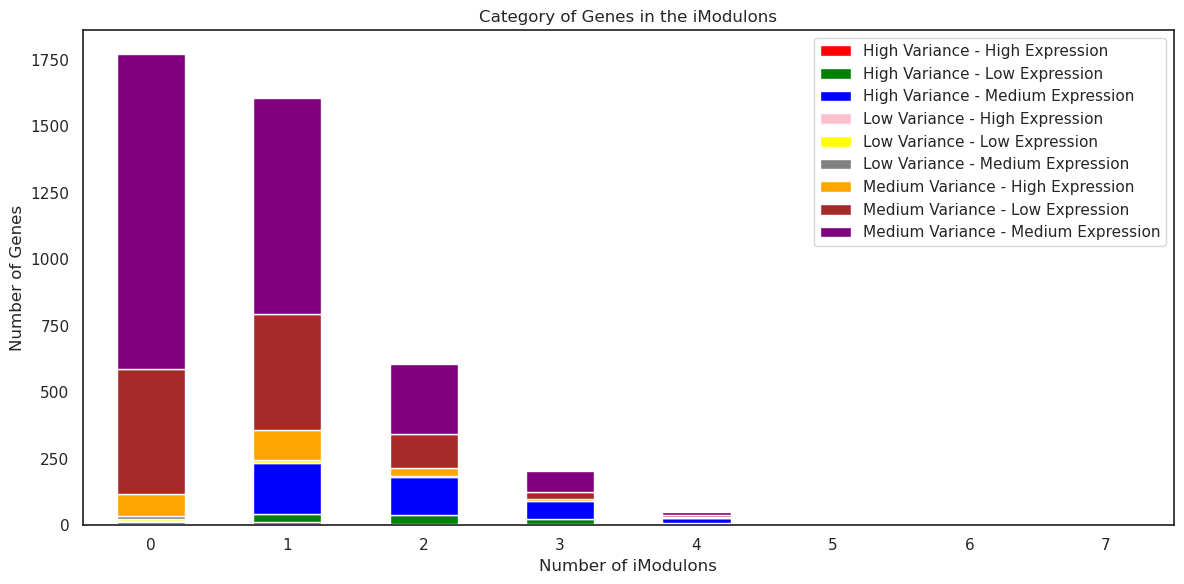

,Low Variance,Medium Variance,High Variance
num_iM,,,
0,1.128668,98.081264,0.790068
1,0.622665,84.806974,14.570361
2,0.826446,69.256198,29.917355
3,0.000000,55.882353,44.117647
4,1.960784,45.098039,52.941176
5,0.000000,45.454545,54.545455
6,0.000000,16.666667,83.333333
7,0.000000,50.000000,50.000000


In [54]:
plot_categorized_histogram(P1K_merged, 'num_iM', 'Variance_Category', 'Expression_Category', 'Category of Genes in the iModulons', 'Number of iModulons', 'Number of Genes')

In [55]:
# Try different cutoffs - low - median boundry

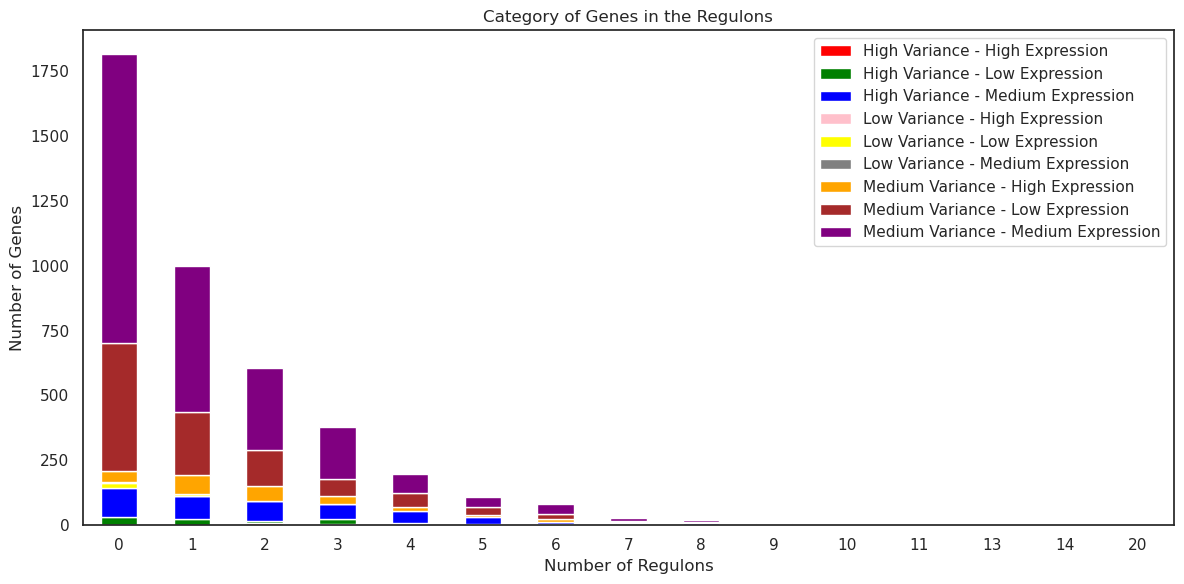

,Low Variance,Medium Variance,High Variance
num_regulators,,,
0,1.321586,90.748899,7.929515
1,0.901804,87.875752,11.222445
2,0.331126,84.271523,15.397351
3,0.263852,78.364116,21.372032
4,0.000000,72.864322,27.135678
5,0.000000,71.559633,28.440367
6,0.000000,82.500000,17.500000
7,0.000000,71.428571,28.571429
8,0.000000,66.666667,33.333333


In [56]:
plot_categorized_histogram(P1K_merged, 'num_regulators', 'Variance_Category', 'Expression_Category', 'Category of Genes in the Regulons', 'Number of Regulons', 'Number of Genes')

In [57]:
P1K_merged['Combined_Category'].value_counts()

Medium Variance - Medium Expression    2358
Medium Variance - Low Expression       1061
High Variance - Medium Expression       438
Medium Variance - High Expression       244
High Variance - Low Expression           95
High Variance - High Expression          25
Low Variance - Low Expression            22
Low Variance - Medium Expression         11
Low Variance - High Expression            3
Name: Combined_Category, dtype: int64

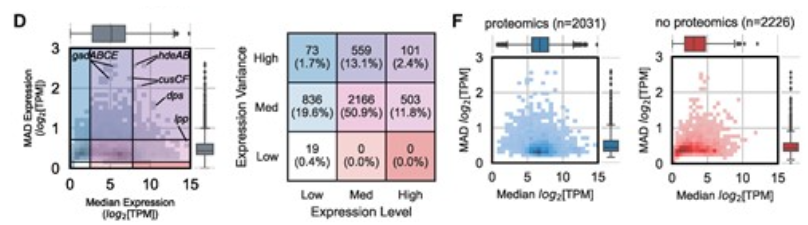

In [58]:
def plot_categorized_histogram_single_category(df, num_iM_col, var_cat_col, title, xlabel, ylabel):
    # Convert the categorical column to string
    df[var_cat_col] = df[var_cat_col].astype(str)
    
    # Define a color palette for distinct categories
    unique_categories = df[var_cat_col].unique()
    colors = plt.cm.get_cmap('viridis', len(unique_categories))

    # Count the occurrences of each category for each num_iM
    category_counts = df.groupby([num_iM_col, var_cat_col]).size().unstack(fill_value=0)

    # Plot the histogram with the specified figure size
    ax = category_counts.plot(kind='bar', stacked=True, figsize=(8, 5), color=[colors(i) for i in range(len(unique_categories))])

    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Show the legend
    ax.legend(title=var_cat_col, loc='best')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

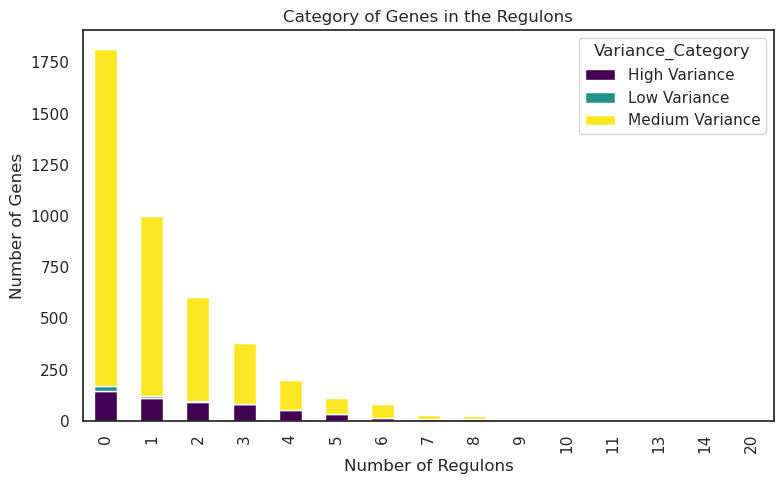

In [59]:
plot_categorized_histogram_single_category(P1K_merged, 'num_regulators', 'Variance_Category', 'Category of Genes in the Regulons', 'Number of Regulons', 'Number of Genes')

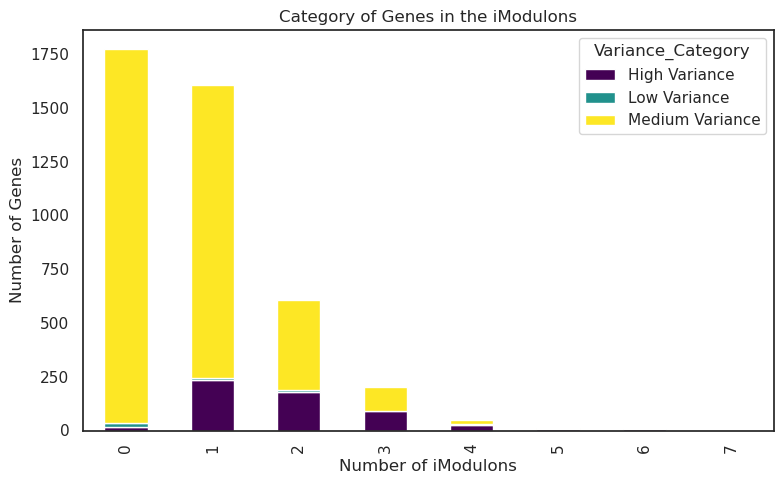

In [60]:
plot_categorized_histogram_single_category(P1K_merged, 'num_iM', 'Variance_Category', 'Category of Genes in the iModulons', 'Number of iModulons', 'Number of Genes')

In [61]:
# show fraction

#### Directly by elbow method

In [62]:
from kneed import KneeLocator

mad_values = P1K_merged['MAD'].values

# Sort the MAD values
sorted_mad_values = sorted(mad_values)

# Find the elbow point
kneedle = KneeLocator(range(len(sorted_mad_values)), sorted_mad_values, curve='convex', direction='increasing')
elbow_point = kneedle.elbow

# Elbow value in terms of MAD
elbow_value = sorted_mad_values[elbow_point]

elbow_value = elbow_value - 0.3

# Define thresholds
high_variance_threshold = elbow_value
low_variance_threshold = elbow_value / 2.5

# Classify the genes
P1K_merged['Variance_Category'] = pd.cut(
    P1K_merged['MAD'],
    bins=[-np.inf, low_variance_threshold, high_variance_threshold, np.inf],
    labels=['Low Variance', 'Medium Variance', 'High Variance']
)

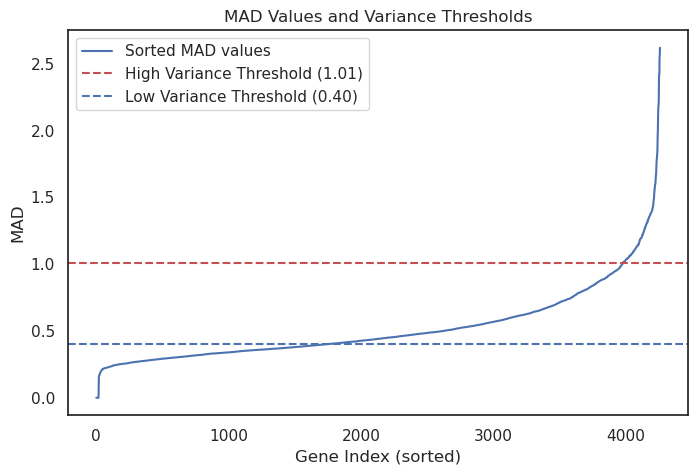

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(sorted_mad_values, label='Sorted MAD values')

# Add high variance threshold
plt.axhline(y=high_variance_threshold, color='r', linestyle='--', label=f'High Variance Threshold ({high_variance_threshold:.2f})')

# Add low variance threshold
plt.axhline(y=low_variance_threshold, color='b', linestyle='--', label=f'Low Variance Threshold ({low_variance_threshold:.2f})')

# Add labels and title
plt.xlabel('Gene Index (sorted)')
plt.ylabel('MAD')
plt.title('MAD Values and Variance Thresholds')
plt.legend()

# Show the plot
plt.show()

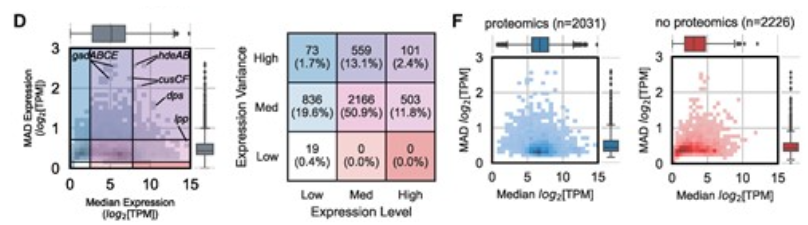

In [64]:
# Extract the log_TPM_median column
log_tpm_median_values = P1K_merged['log_TPM_median'].values

# Sort the log_TPM_median values
sorted_log_tpm_median_values = sorted(log_tpm_median_values)

# Find the elbow point
kneedle_tpm = KneeLocator(range(len(sorted_log_tpm_median_values)), sorted_log_tpm_median_values, curve='convex', direction='increasing')
elbow_point_tpm = kneedle_tpm.elbow

# Elbow value in terms of log_TPM_median
elbow_value_tpm = sorted_log_tpm_median_values[elbow_point_tpm]

elbow_value_tpm = elbow_value_tpm - 1.2

# Define thresholds
high_expression_threshold = elbow_value_tpm
low_expression_threshold = elbow_value_tpm / 2 # This is arbitrary, adjust as needed

# Classify the genes
P1K_merged['Expression_Category'] = pd.cut(
    P1K_merged['log_TPM_median'],
    bins=[-np.inf, low_expression_threshold, high_expression_threshold, np.inf],
    labels=['Low Expression', 'Medium Expression', 'High Expression']
)

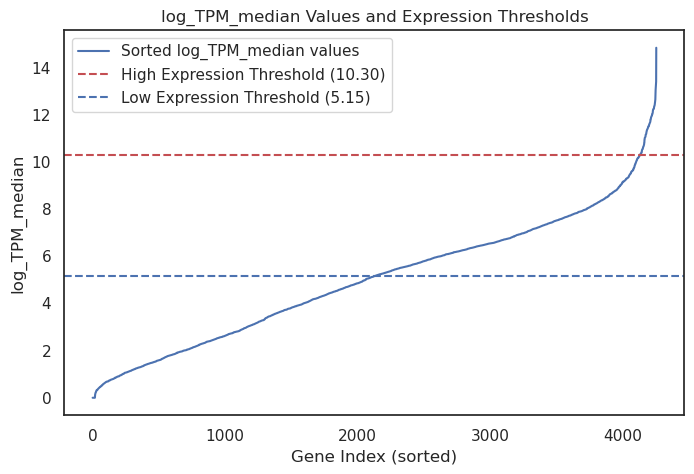

In [65]:
plt.figure(figsize=(8, 5))
plt.plot(sorted_log_tpm_median_values, label='Sorted log_TPM_median values')

# Add high expression threshold
plt.axhline(y=high_expression_threshold, color='r', linestyle='--', label=f'High Expression Threshold ({high_expression_threshold:.2f})')

# Add low expression threshold
plt.axhline(y=low_expression_threshold, color='b', linestyle='--', label=f'Low Expression Threshold ({low_expression_threshold:.2f})')

# Add labels and title
plt.xlabel('Gene Index (sorted)')
plt.ylabel('log_TPM_median')
plt.title('log_TPM_median Values and Expression Thresholds')
plt.legend()

# Show the plot
plt.show()

In [66]:
P1K_merged

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm,Variance_Category,Expression_Category,Combined_Category
thrA,0.899430,0.686194,thrA KO,0.076638,Cysteine-1,0.075628,Thiamine-1,3,3,0.708056,9.605329,11.771901,4.398331,Medium Variance,Medium Expression,Medium Variance - High Expression
thrB,0.808533,0.254512,thrA KO,0.227884,Leu/Val/Ile,0.103394,Leucine,1,2,0.698585,9.225274,7.560994,3.900854,Medium Variance,Medium Expression,Medium Variance - High Expression
thrC,0.824916,0.246587,thrA KO,0.234486,Leu/Val/Ile,0.155906,Dipeptide,1,1,0.612527,9.272277,7.647762,3.681351,Medium Variance,Medium Expression,Medium Variance - High Expression
yaaX,0.689923,0.171007,Leu/Val/Ile,0.169602,Nucleotide Stress,0.095365,Glycolate,0,3,0.737335,6.283661,11.817918,4.395201,Medium Variance,Medium Expression,Medium Variance - Medium Expression
yaaA,0.638300,0.428612,OxyR,0.171808,Cold Shock,0.129606,UC-8,0,1,0.306569,6.346626,8.667107,1.920613,Low Variance,Medium Expression,Medium Variance - Medium Expression
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yneP,0.748917,0.629455,yneP,0.075002,GadXW,0.047460,Resistance,0,1,1.059936,1.140369,4.458041,2.868327,High Variance,Low Expression,High Variance - Low Expression
ynfT,0.467147,0.424437,Cold Shock,0.045140,NRZ,0.033476,LPS,0,2,1.776698,2.466008,7.650393,6.189466,High Variance,Low Expression,High Variance - Low Expression
yoaL,0.333663,0.102746,CpxR,0.066571,Cellulose,0.044315,ppGpp,0,2,0.540346,5.048395,5.552991,2.841891,Medium Variance,Low Expression,Medium Variance - Medium Expression
yqhI,0.894360,0.738529,yqhI,0.091457,UC-8,0.084815,Resistance,0,2,1.195671,1.195671,7.305199,4.985373,High Variance,Low Expression,High Variance - Low Expression


In [67]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_categorized_histogram(df, num_iM_col, var_cat_col, exp_cat_col, title, xlabel, ylabel):
    # Convert categorical columns to strings and create a new combined category
    df['Combined_Category'] = df[var_cat_col].astype(str) + ' - ' + df[exp_cat_col].astype(str)
    
    # Define a color palette with 9 distinct colors
    colors = {
        'High Variance - High Expression': 'red',
        'High Variance - Medium Expression': 'blue',
        'High Variance - Low Expression': 'green',
        'Medium Variance - High Expression': 'orange',
        'Medium Variance - Medium Expression': 'purple',
        'Medium Variance - Low Expression': 'brown',
        'Low Variance - High Expression': 'pink',
        'Low Variance - Medium Expression': 'gray',
        'Low Variance - Low Expression': 'yellow'
    }

    # Count the occurrences of each combined category for each num_iM
    category_counts = df.groupby([num_iM_col, 'Combined_Category']).size().unstack(fill_value=0)

    # Plot the histogram
    category_counts.plot(kind='bar', stacked=True, color=[colors[cat] for cat in category_counts.columns], figsize=(12, 6))

    # Set the title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)

    # Show the legend
    plt.legend(title='', loc='best')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Calculate percentages for Low, Medium, and High Variance categories
    variance_categories = ['Low Variance', 'Medium Variance', 'High Variance']
    percentage_df = pd.DataFrame(index=category_counts.index, columns=variance_categories, dtype=float)
    
    for variance in variance_categories:
        # Sum the sub-categories for each variance level
        variance_cols = [col for col in category_counts.columns if col.startswith(variance)]
        variance_sum = category_counts[variance_cols].sum(axis=1)
        # Calculate percentage
        total_counts = category_counts.sum(axis=1)
        percentage_df[variance] = (variance_sum / total_counts) * 100

    return percentage_df

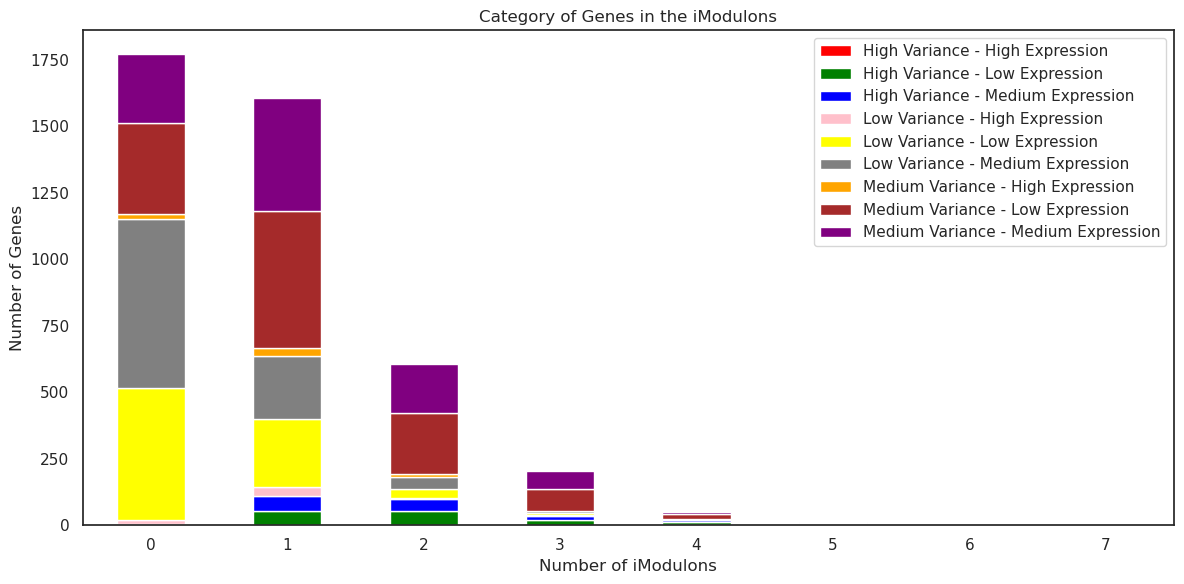

,Low Variance,Medium Variance,High Variance
num_iM,,,
0,64.785553,35.045147,0.169300
1,32.752179,60.398506,6.849315
2,13.553719,69.917355,16.528926
3,8.823529,73.529412,17.647059
4,3.921569,58.823529,37.254902
5,18.181818,27.272727,54.545455
6,0.000000,50.000000,50.000000
7,0.000000,50.000000,50.000000


In [68]:
plot_categorized_histogram(P1K_merged, 'num_iM', 'Variance_Category', 'Expression_Category', 'Category of Genes in the iModulons', 'Number of iModulons', 'Number of Genes')

In [69]:
# Try different cutoffs - low - median boundry

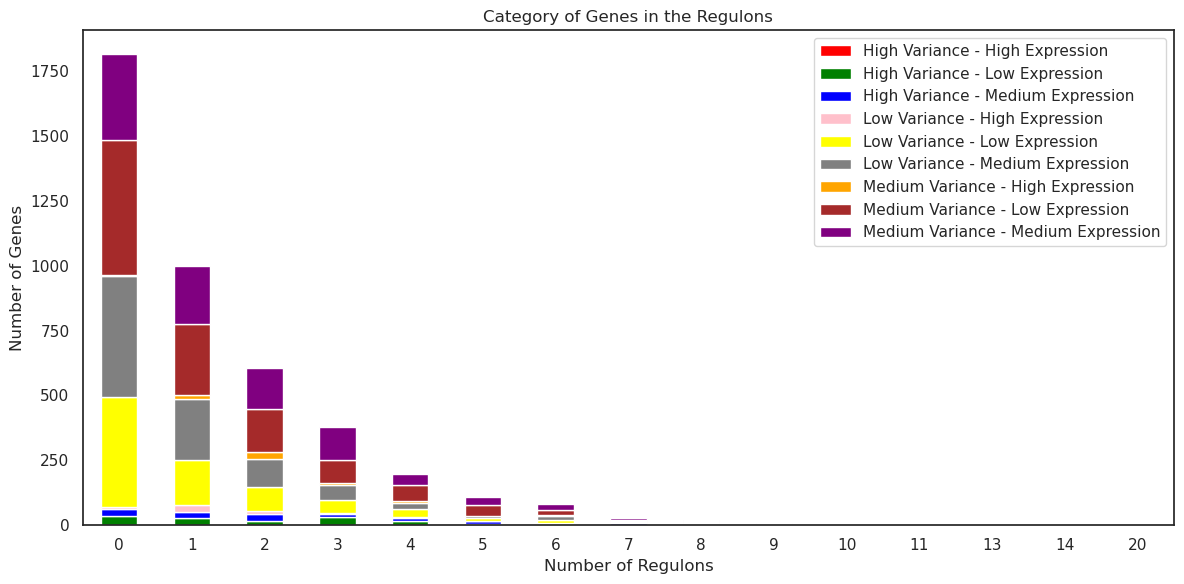

,Low Variance,Medium Variance,High Variance
num_regulators,,,
0,49.559471,47.081498,3.359031
1,43.687375,51.102204,5.210421
2,35.099338,57.450331,7.450331
3,29.551451,58.839050,11.609499
4,29.145729,56.783920,14.070352
5,18.348624,67.889908,13.761468
6,33.750000,56.250000,10.000000
7,21.428571,50.000000,28.571429
8,23.809524,52.380952,23.809524


In [70]:
plot_categorized_histogram(P1K_merged, 'num_regulators', 'Variance_Category', 'Expression_Category', 'Category of Genes in the Regulons', 'Number of Regulons', 'Number of Genes')

In [71]:
P1K_merged['Combined_Category'].value_counts()

Medium Variance - Low Expression       1184
Medium Variance - Medium Expression     952
Low Variance - Medium Expression        926
Low Variance - Low Expression           798
High Variance - Low Expression          141
High Variance - Medium Expression       133
Medium Variance - High Expression        65
Low Variance - High Expression           54
High Variance - High Expression           4
Name: Combined_Category, dtype: int64

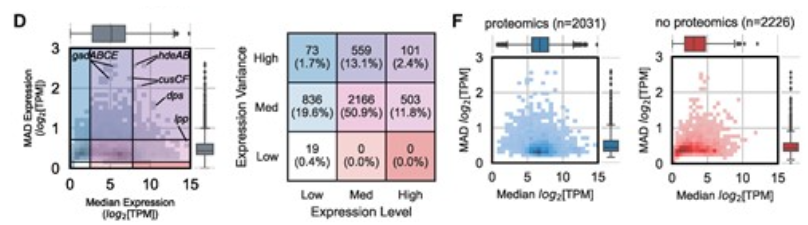

In [72]:
def plot_categorized_histogram_single_category(df, num_iM_col, var_cat_col, title, xlabel, ylabel):
    # Convert the categorical column to string
    df[var_cat_col] = df[var_cat_col].astype(str)
    
    # Define a color palette for distinct categories
    unique_categories = df[var_cat_col].unique()
    colors = plt.cm.get_cmap('viridis', len(unique_categories))

    # Count the occurrences of each category for each num_iM
    category_counts = df.groupby([num_iM_col, var_cat_col]).size().unstack(fill_value=0)

    # Plot the histogram with the specified figure size
    ax = category_counts.plot(kind='bar', stacked=True, figsize=(8, 5), color=[colors(i) for i in range(len(unique_categories))])

    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Show the legend
    ax.legend(title=var_cat_col, loc='best')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

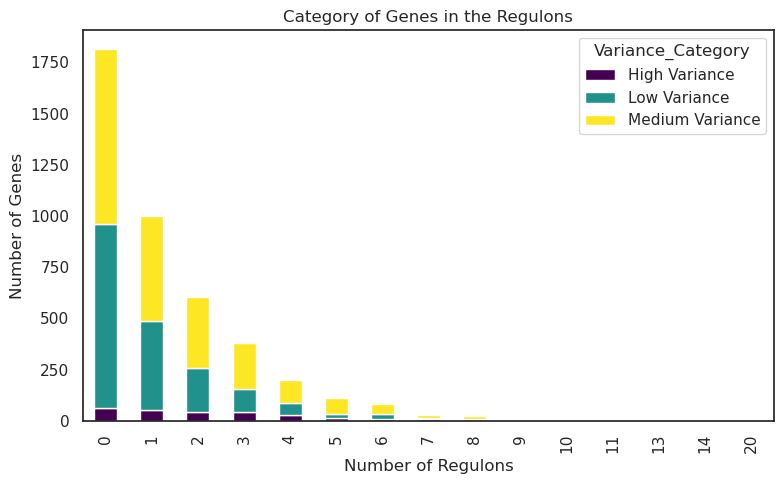

In [73]:
plot_categorized_histogram_single_category(P1K_merged, 'num_regulators', 'Variance_Category', 'Category of Genes in the Regulons', 'Number of Regulons', 'Number of Genes')

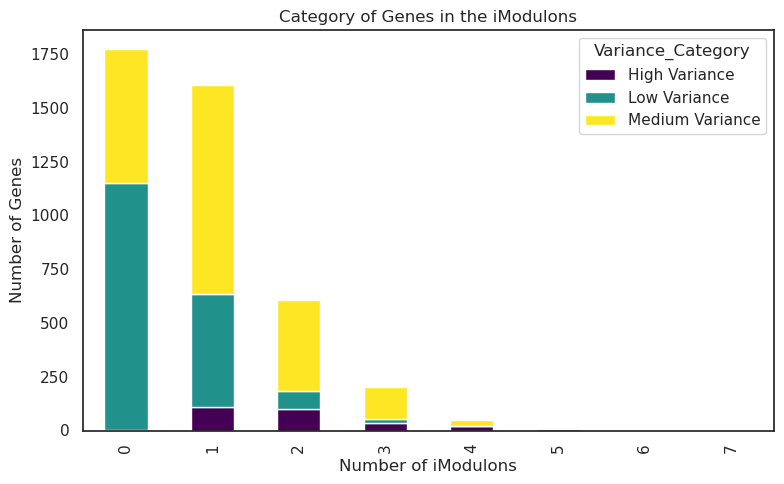

In [74]:
plot_categorized_histogram_single_category(P1K_merged, 'num_iM', 'Variance_Category', 'Category of Genes in the iModulons', 'Number of iModulons', 'Number of Genes')

## How many regulators (TFs/Sigma factors) have iModulons associated with them?

In [75]:
# Separate unique regulator-iM associations vs multi-regulator to a single iM
# no, unique, multi-

In [76]:
P1K_iM_table = pd.read_csv('/home/gaoyuan/PhD/ICA_Extension_Mechanism/p1k_data_files/iM_table.csv', index_col=0)

In [77]:
P1K_iM_table['regulator_readable'] = P1K_iM_table['regulator_readable'].astype('str')

In [78]:
P1K_iM_table_with_regulator = P1K_iM_table[P1K_iM_table['regulator_readable'] != 'nan']

In [79]:
P1K_iM_table_with_regulator

,name,regulator_readable,function,category,n_genes,exp_var,precision,recall,category_num
k,,,,,,,,,
0,Sugar Diacid,CdaR,Transport and catabolism of carbohydrate diaci...,Carbon Metabolism,14,0.002413,0.642857,1.000000,0
1,Translation,DksA,Ribosome biogenesis,Translation,53,0.007469,0.830189,0.392857,1
3,OxyR,OxyR,"Oxidative stress response, especially peroxide",Redox Stress,38,0.001747,0.421053,0.551724,3
4,FlhDC-2,FlhDC,Flagellum biosynthesis and export,Extracellular Structures,43,0.030021,0.860465,0.456790,4
5,Osmoprotectant,RpoS and ppGpp and IHF and H-NS,Transport of osmoprotectant glycine betaine,Envelope Stress,4,0.004189,0.750000,0.375000,5
...,...,...,...,...,...,...,...,...,...
185,gcvB,gcvB,Amino acid transport,Amino Acid Metabolism,76,0.005554,0.184211,0.245614,185
186,Glutarate,RpoS and H-NS and Crp and Lrp and GlaR and ppGpp,Glutarate/aminobutyrate transport and catabolism,Carbon Metabolism,5,0.003170,1.000000,1.000000,186
191,Tryptophanase,Crp and TorR and Nac and L-tryptophan,Tryptophan import and catabolism via tryptopha...,Amino Acid Metabolism,2,0.003248,1.000000,1.000000,191


In [80]:
## Single Regulator - single iM

In [81]:
single_regulator_iM = P1K_iM_table_with_regulator[P1K_iM_table_with_regulator['regulator_readable'].str.contains(' ') == False]

In [82]:
single_regulator_iM.shape

(56, 9)

In [83]:
single_regulator_iM

,name,regulator_readable,function,category,n_genes,exp_var,precision,recall,category_num
k,,,,,,,,,
0,Sugar Diacid,CdaR,Transport and catabolism of carbohydrate diaci...,Carbon Metabolism,14,0.002413,0.642857,1.000000,0
1,Translation,DksA,Ribosome biogenesis,Translation,53,0.007469,0.830189,0.392857,1
3,OxyR,OxyR,"Oxidative stress response, especially peroxide",Redox Stress,38,0.001747,0.421053,0.551724,3
4,FlhDC-2,FlhDC,Flagellum biosynthesis and export,Extracellular Structures,43,0.030021,0.860465,0.456790,4
6,Glutamine,NtrC,Glutamine transport and synthesis,Nitrogen Metabolism,9,0.005122,0.555556,0.294118,6
13,RpoH,RpoH,Global heat shock response during log-phase; r...,Temperature Shock,41,0.003987,0.829268,0.242857,13
18,Methionine,MetJ,Methionine transport and biosynthesis,Amino Acid Metabolism,21,0.006690,0.523810,0.733333,18
22,SoxS,SoxS,"Superoxide/nitric oxide sensing and removal, p...",Redox Stress,117,0.004168,0.273504,0.761905,22
24,YjfJ,YjfJ,Putative heat responsive regulon,Temperature Shock,4,0.002200,NaN,NaN,24


In [84]:
single_regulator_iM['regulator_readable'].value_counts()

Fnr      3
Crp      2
FlhDC    2
PhoB     2
Fur      2
CysB     2
PyrR     1
YgeV     1
sdhX     1
YgbI     1
ArgP     1
FliA     1
BtsR     1
CdaR     1
Nac      1
ppGpp    1
ArgR     1
RcnR     1
YmfT     1
YcjW     1
NrdR     1
Cra      1
MalT     1
FadR     1
DhaR     1
RcsAB    1
KdpE     1
YieP     1
LexA     1
OxyR     1
NtrC     1
RpoH     1
MetJ     1
SoxS     1
YjfJ     1
Lrp      1
CpxR     1
EvgA     1
BirA     1
BasR     1
CsqR     1
RpoS     1
PhoP     1
ZraR     1
OmpR     1
RpoE     1
ArcA     1
DksA     1
gcvB     1
Name: regulator_readable, dtype: int64

In [85]:
len(single_regulator_iM['regulator_readable'].unique())

49

In [86]:
def count_regulators(dataframe, column_name):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = dataframe.copy()
    
    # Ensure there are no leading or trailing spaces in the column values
    df_copy.loc[:, column_name] = df_copy[column_name].str.strip()
    
    # Split the column values by ' and ' or ' or ' with spaces before and after and stack them into a single series
    regulators = df_copy[column_name].str.split(r'\s+and\s+|\s+or\s+', expand=True).stack()
    
    # Remove any potential empty strings
    regulators = regulators[regulators != '']
    
    # Count the occurrences of each unique regulator
    regulator_counts = regulators.value_counts().reset_index()
    
    # Rename the columns
    regulator_counts.columns = ['regulator', 'counts']
    
    return regulator_counts


In [87]:
regulator_iM_counts = count_regulators(P1K_iM_table_with_regulator, 'regulator_readable')

In [88]:
# Unique iM regulator
# 81
regulator_iM_counts[regulator_iM_counts ['counts'] == 1]

,regulator,counts
42,YgeV,1
43,ArgP,1
44,YgbI,1
45,FadR,1
46,NagC,1
...,...,...
118,BasR,1
119,MarA,1
120,BluR,1
121,BirA,1


In [89]:
# Nulti iM regulator
# 41
regulator_iM_counts[regulator_iM_counts ['counts'] != 1]

,regulator,counts
0,Crp,24
1,IHF,16
2,Fnr,13
3,RpoS,11
4,ppGpp,10
5,RpoN,8
6,NarL,7
7,ArcA,6
8,Lrp,5
9,NtrC,4


In [90]:
# only in regulonDB, not in any iM

RegulonDB_TRN.columns

Index(['FecI', 'FliA', 'RpoD', 'RpoE', 'RpoH', 'RpoN', 'RpoS', 'AcrR', 'Ada',
       'AdiY',
       ...
       'YefM', 'YefMB', 'YgiV', 'YhaJ', 'YiaU', 'YjjQ', 'YqhC', 'ZntR', 'ZraR',
       'Zur'],
      dtype='object', length=259)

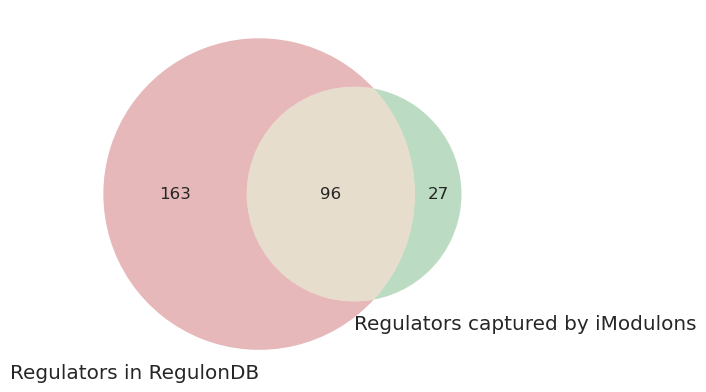

In [91]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

venn2([set(RegulonDB_TRN.columns), set(regulator_iM_counts['regulator'])], set_labels=('Regulators in RegulonDB', 'Regulators captured by iModulons'))

# Show the plot
plt.show()

In [92]:
## Print

## For genes associated to iMs, how much explained variance is captured by the top iM?

In [93]:
def plot_stacked_histogram(df, variance_col, num_iM_col):
    # Copy the DataFrame
    df_copy = df.copy()

    # Separate the data
    in_ims = df_copy[df_copy[num_iM_col] != 0][variance_col]
    not_in_ims = df_copy[df_copy[num_iM_col] == 0][variance_col]

    # Plot histogram
    plt.hist([not_in_ims, in_ims], bins=10, stacked=True, color=['lightblue', 'salmon'], label=['Not in any iMs', 'in iMs'])
    plt.xlabel('Top Explained Variance')
    plt.ylabel('Frequency')
    plt.title('Explained Variance from the top iM')
    plt.legend()
    plt.show()

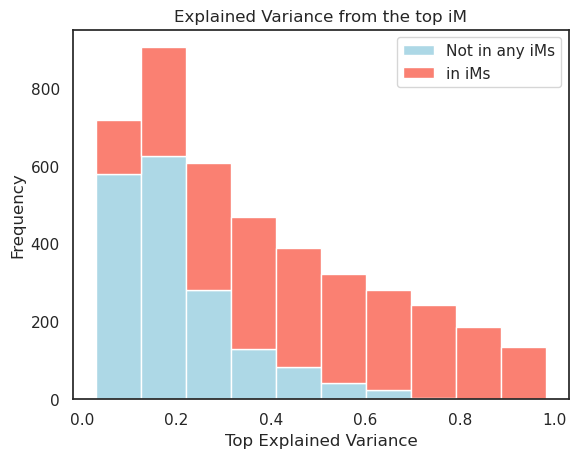

In [94]:
plot_stacked_histogram(P1K_merged, 'Top_1_Explained_Variance', 'num_iM')

In [95]:
# Cases for top left - low top exp var - but in iMs

In [96]:
P1K_merged[(P1K_merged['Top_1_Explained_Variance'] < 0.1) & (P1K_merged['num_iM'] >0)]

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm,Variance_Category,Expression_Category,Combined_Category
mog,0.506701,0.085929,UC-5,0.075019,Cellulose,0.061941,RpoS,0,2,0.338561,6.015463,6.399666,1.675159,Low Variance,Medium Expression,Low Variance - Medium Expression
mbiA,-0.111055,0.090604,UC-5,0.079584,DNA Damage,0.073846,UC-6,1,1,0.344671,0.594516,4.124902,1.753399,Low Variance,Low Expression,Low Variance - Low Expression
fixX,0.016148,0.070135,UC-2,0.036621,Efflux Pump,0.033455,LPS,2,1,0.452503,1.067281,4.073628,2.146699,Medium Variance,Low Expression,Medium Variance - Low Expression
cra,0.638262,0.079509,Suf System,0.074772,UC-3,0.074057,Tryptophanase,0,2,0.270395,7.066895,9.276871,1.929097,Low Variance,Medium Expression,Low Variance - Medium Expression
dgt,0.275157,0.083282,Fnr-1,0.075223,SoxS,0.049999,Lrp,0,2,0.275826,5.451978,5.514533,1.685060,Low Variance,Medium Expression,Low Variance - Medium Expression
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hokA,0.035485,0.073324,SSW SNPs,0.051889,Resistance,0.049770,Rhamnose,0,1,0.695966,0.695966,4.159089,2.180750,Medium Variance,Low Expression,Medium Variance - Low Expression
ymjB,0.257451,0.041217,Nitrate/Nitrite,0.037120,ldrC,0.029970,GadXW,1,4,0.000000,0.000000,5.185074,2.287185,Low Variance,Low Expression,Low Variance - Low Expression
yniD,-0.070384,0.073831,Resistance,0.058614,yneP,0.047505,Translation,0,3,0.729380,3.730415,6.796104,3.786935,Medium Variance,Low Expression,Medium Variance - Low Expression
yshB,0.577362,0.094962,IS Elements-2,0.058995,Nucleoside,0.044643,Lrp,0,1,0.901976,8.070179,8.685762,3.618214,Medium Variance,Medium Expression,Medium Variance - Medium Expression


In [97]:
def plot_stacked_histogram(df, variance_col, num_iM_col):
    # Copy the DataFrame
    df_copy = df.copy()

    # Separate the data
    in_ims = df_copy[df_copy[num_iM_col] != 0][variance_col]
    not_in_ims = df_copy[df_copy[num_iM_col] == 0][variance_col]

    # Plot histogram
    plt.hist([not_in_ims, in_ims], bins=10, stacked=True, color=['lightblue', 'salmon'], label=['Not in any regulon', 'in regulons'])
    plt.xlabel('Top Explained Variance')
    plt.ylabel('Frequency')
    plt.title('Explained Variance from the top iM')
    plt.legend()
    plt.show()

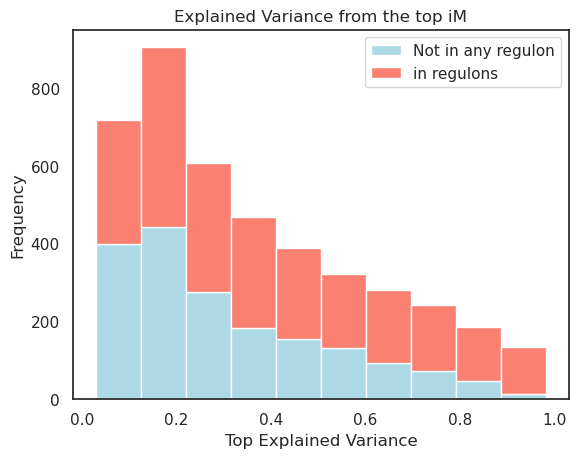

In [98]:
plot_stacked_histogram(P1K_merged, 'Top_1_Explained_Variance', 'num_regulators')

In [99]:
def plot_stacked_histogram_three_categories(df, variance_col, category_col):
    # Copy the DataFrame
    df_copy = df.copy()

    # Define categories and colors
    categories = df_copy[category_col].unique()
    categories = ['Low Variance', 'Medium Variance', 'High Variance']
    colors = ['lightblue', 'lightgreen', 'salmon']
    if len(categories) > 3:
        raise ValueError("There are more than three categories in the Variance_Category column.")

    # Separate the data
    separated_data = [df_copy[df_copy[category_col] == category][variance_col] for category in categories]

    # Plot histogram
    plt.hist(separated_data, bins=10, stacked=True, color=colors[:len(categories)], label=categories)
    plt.xlabel('Top Explained Variance')
    plt.ylabel('Frequency')
    plt.title('Explained Variance from the top iM')
    plt.legend()
    plt.show()

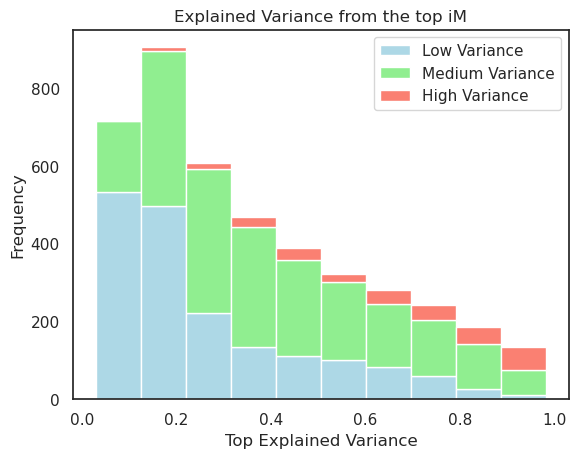

In [100]:
plot_stacked_histogram_three_categories(P1K_merged, 'Top_1_Explained_Variance', 'Variance_Category')

## How many genes are explained well by their top iM?

**All the genes with more than 80% exp var by top component are in iModulons**

In [101]:
(P1K_merged['Top_1_Explained_Variance'] > 0.8).sum()

309

In [102]:
(P1K_merged[P1K_merged['num_iM'] != 0]['Top_1_Explained_Variance'] > 0.8).sum()

309

In [103]:
(P1K_merged[P1K_merged['num_iM'] == 0]['Top_1_Explained_Variance'] > 0.8).sum()

0

**93.5% of the genes with more than 50% exp var by top component are in iModulons**

In [104]:
(P1K_merged['Top_1_Explained_Variance'] > 0.5).sum()

1190

In [105]:
# in iM
(P1K_merged[P1K_merged['num_iM'] != 0]['Top_1_Explained_Variance'] > 0.5).sum()

1113

In [106]:
(P1K_merged[P1K_merged['num_iM'] == 0]['Top_1_Explained_Variance'] > 0.5).sum()

77

**91.0% of the genes with more than 80% exp var in total are in iModulons**

In [107]:
(P1K_merged['Total_Explained_Variance'] > 0.8).sum()

1276

In [108]:
# in iM
(P1K_merged[P1K_merged['num_iM'] != 0]['Total_Explained_Variance'] > 0.8).sum()

1161

In [109]:
(P1K_merged[P1K_merged['num_iM'] == 0]['Total_Explained_Variance'] > 0.8).sum()

115

In [110]:
# Venn diagram for category 2&3

**72.3% of the genes with more than 50% exp var in total are in iModulons**

In [111]:
(P1K_merged['Total_Explained_Variance'] > 0.5).sum()

2981

In [112]:
(P1K_merged[P1K_merged['num_iM'] != 0]['Total_Explained_Variance'] > 0.5).sum()

2156

In [113]:
(P1K_merged[P1K_merged['num_iM'] == 0]['Total_Explained_Variance'] > 0.5).sum()

825

## How many genes (even not in an iModulon) can be explained reasonably well by a single iM?

In [114]:
# An appropriate cutoff for what "explained well" means needs to be determined

In [115]:
# At least in one iM

(P1K_merged[P1K_merged['num_iM'] != 0]['Top_1_Explained_Variance'] > 0.5).sum()

1113

In [116]:
# Not in iMs

(P1K_merged[P1K_merged['num_iM'] == 0]['Top_1_Explained_Variance'] > 0.5).sum()

77

### four scatter plots - 0.2 0.4 0.6 0.8 exp var - genes close to these values

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter_with_fit(X, A, gene_name, imodulon_name):
    # Extract the rows
    x_values = X.loc[gene_name].values.reshape(-1, 1)
    y_values = A.loc[imodulon_name].values
    
    plt.figure(figsize=(15, 2))
    # Create scatter plot
    plt.scatter(x_values, y_values, label='Data points')

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    
    # Plot the line of best fit
    plt.plot(x_values, y_pred, color='red', label='Line of best fit')

    # Calculate the R^2 value
    r2 = r2_score(y_values, y_pred)
    
    # Display the plot with labels and legend
    plt.xlabel(gene_name)
    plt.ylabel(imodulon_name)
    plt.title(f'Scatter Plot of {gene_name} Expression and {imodulon_name} Activity\n$R^2$ = {r2:.2f}')
    plt.legend()
    plt.show()

#### 0.2 exp var for top iM

In [118]:
(P1K_merged[(P1K_merged['num_iM'] != 0) & (P1K_merged['Top_1_Explained_Variance'] > 0.198) & (P1K_merged['Top_1_Explained_Variance'] <= 0.202)])

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm,Variance_Category,Expression_Category,Combined_Category
aceE,0.496320,0.198046,Pyruvate-1,0.099905,Tryptophanase,0.094199,cyoB/ndh/nuoB KO-2,6,2,0.514809,10.141470,9.902395,2.565130,Medium Variance,Medium Expression,Medium Variance - Medium Expression
ygfZ,0.567229,0.200985,SoxS,0.112400,Cold Shock,0.086215,ppGpp,0,1,0.370070,8.139202,8.485120,2.326982,Low Variance,Medium Expression,Low Variance - Medium Expression
yohO,0.730582,0.201530,Cold Shock,0.167250,ArcA,0.163389,minicoli KOs,1,5,0.766030,4.710898,7.734391,5.193217,Medium Variance,Low Expression,Medium Variance - Low Expression


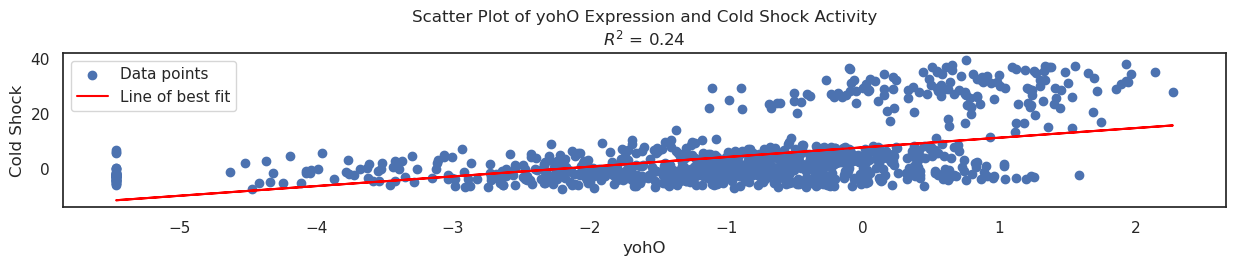

In [119]:
plot_scatter_with_fit(P1K_X, P1K_A, 'yohO', 'Cold Shock')

#### 0.4 exp var for top iM

In [120]:
(P1K_merged[(P1K_merged['num_iM'] != 0) & (P1K_merged['Top_1_Explained_Variance'] > 0.399) & (P1K_merged['Top_1_Explained_Variance'] <= 0.401)])

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm,Variance_Category,Expression_Category,Combined_Category
thiB,0.923394,0.399882,Thiamine-2,0.362027,minicoli KOs,0.276734,Thiamine-1,1,3,0.926312,6.463760,8.370243,4.566084,Medium Variance,Medium Expression,Medium Variance - Medium Expression
tfaP,0.426366,0.400820,e14 Del,0.074898,Cellulose,0.065709,Membrane,0,1,0.567003,2.047423,5.560001,3.349763,Medium Variance,Low Expression,Medium Variance - Low Expression
ydhP,0.728553,0.399998,crp KO-1,0.133989,UC-3,0.087100,Sulfate,0,2,0.525878,4.272419,6.737068,2.929794,Medium Variance,Low Expression,Medium Variance - Low Expression
hcaR,0.866541,0.399631,ArcA,0.366989,UC-3,0.062755,Cold Shock,4,2,0.864447,5.363972,7.747803,5.458019,Medium Variance,Medium Expression,Medium Variance - Medium Expression
agaV,0.654332,0.399785,UC-3,0.120964,Acetate,0.111584,Tryptophanase,3,1,0.464450,2.312216,6.311997,3.353274,Medium Variance,Low Expression,Medium Variance - Low Expression
bfd,0.876044,0.400080,Fur-2,0.159288,minicoli KOs,0.134409,NrdR,2,1,1.046325,7.030968,10.571173,6.213533,High Variance,Medium Expression,High Variance - Medium Expression
waaL,0.614756,0.400375,LPS,0.072282,gcvB,0.054997,UC-7,3,1,0.836676,5.554878,8.466801,4.314322,Medium Variance,Medium Expression,Medium Variance - Medium Expression
dinD,0.875722,0.400693,DNA Damage,0.331136,Cold Shock,0.169690,UC-3,1,3,0.577858,3.731381,7.471783,4.297600,Medium Variance,Low Expression,Medium Variance - Low Expression
yigG,0.692606,0.400823,gcvB,0.158401,LPS,0.151844,Nucleotide Stress,1,2,0.614868,1.269864,4.839620,3.007742,Medium Variance,Low Expression,Medium Variance - Low Expression
aceA,0.919733,0.400599,Glyoxylate,0.219348,Glycolate,0.103584,Fatty Acid,4,1,1.124310,10.111705,10.175448,5.794129,High Variance,Medium Expression,High Variance - Medium Expression


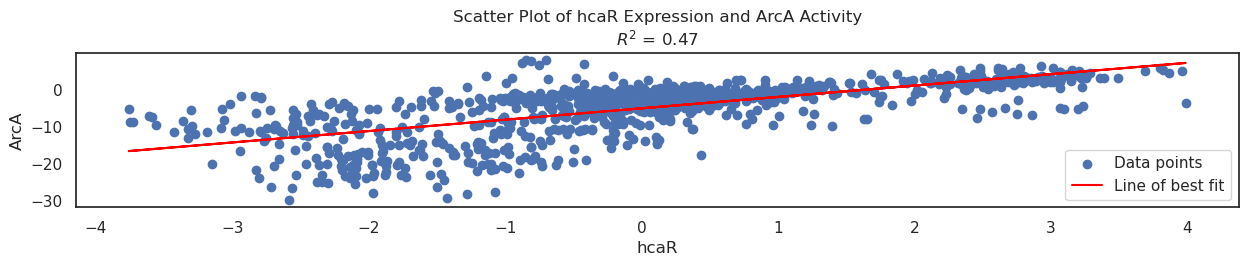

In [121]:
plot_scatter_with_fit(P1K_X, P1K_A, 'hcaR', 'ArcA')

#### 0.6 exp var for top iM

In [122]:
(P1K_merged[(P1K_merged['num_iM'] != 0) & (P1K_merged['Top_1_Explained_Variance'] > 0.599) & (P1K_merged['Top_1_Explained_Variance'] <= 0.601)])

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm,Variance_Category,Expression_Category,Combined_Category
artP,0.828126,0.600421,minicoli KOs,0.141570,Arginine,0.090312,ROS TALE Del-2,3,2,0.484236,7.316250,10.318700,3.243704,Medium Variance,Medium Expression,Medium Variance - Medium Expression
yncG,0.905237,0.599498,RpoS,0.371730,UC-7,0.303266,PAL 10 Del,0,2,0.895491,3.907550,7.616268,4.691252,Medium Variance,Low Expression,Medium Variance - Low Expression
elaB,0.933595,0.600006,RpoS,0.252625,minicoli KOs,0.114345,UC-7,2,1,1.180897,9.941173,13.276604,6.203207,High Variance,Medium Expression,High Variance - Medium Expression


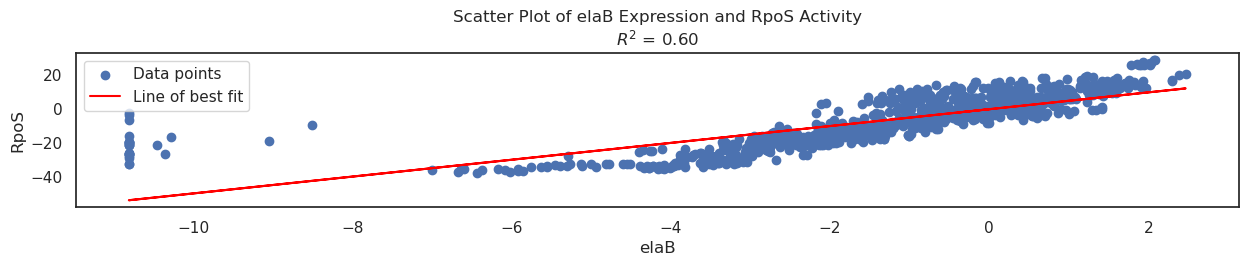

In [123]:
plot_scatter_with_fit(P1K_X, P1K_A, 'elaB', 'RpoS')

In [124]:
# left corners - projects within the figure

#### 0.8 exp var for top iM

In [125]:
(P1K_merged[(P1K_merged['num_iM'] != 0) & (P1K_merged['Top_1_Explained_Variance'] > 0.799) & (P1K_merged['Top_1_Explained_Variance'] <= 0.801)])

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm,Variance_Category,Expression_Category,Combined_Category
rfbB,0.945884,0.799789,minicoli KOs,0.083714,LPS,0.062427,Membrane,2,1,0.305180,7.773383,9.220418,1.944107,Low Variance,Medium Expression,Low Variance - Medium Expression
tdcE,0.900021,0.799404,Thr/Ser-1,0.083369,Thr/Ser-2,0.069532,ppGpp,4,1,0.387620,2.174176,12.946761,2.163202,Low Variance,Low Expression,Low Variance - Low Expression
livM,0.906324,0.800637,Lrp,0.066032,Hot TALE 16,0.047551,Tryptophan,2,2,0.502561,7.173051,8.618589,5.831037,Medium Variance,Medium Expression,Medium Variance - Medium Expression


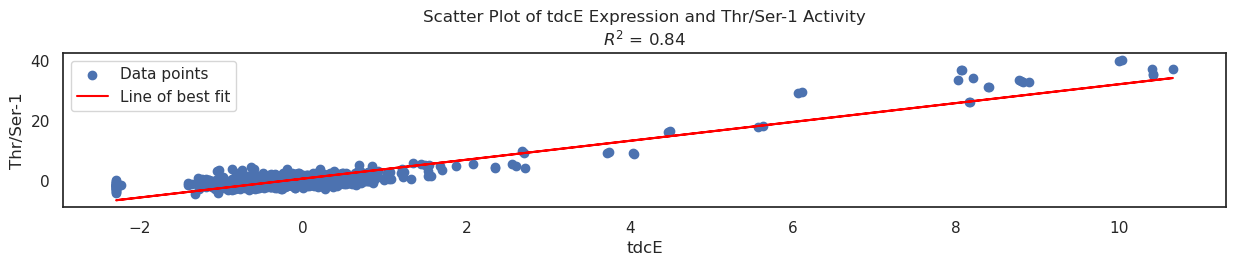

In [126]:
plot_scatter_with_fit(P1K_X, P1K_A, 'tdcE', 'Thr/Ser-1')

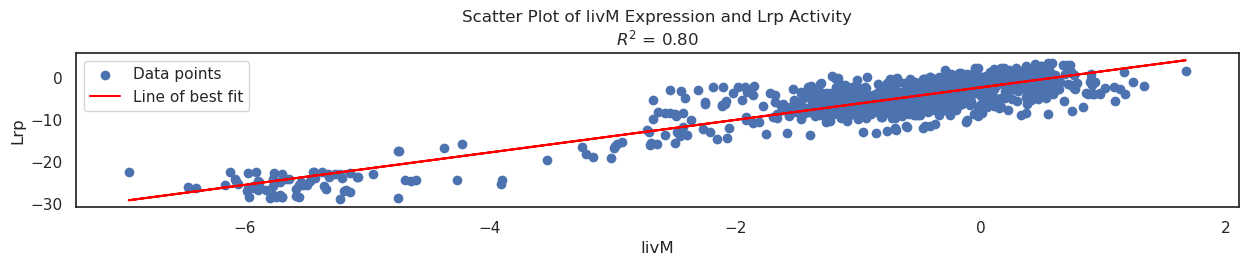

In [127]:
plot_scatter_with_fit(P1K_X, P1K_A, 'livM', 'Lrp')

## What are the final counts in each category of gene?

### 4257

Categories:
1) **(HIGH Top iM exp var) - 1190**
   - Gene is explained well by an iModulon
2) **(LOW Top iM exp var - LOW VARIANCE - LOW TPM median - LOW Range) - 402**
   - Gene is not explained well but is poorly expressed on all conditions 
3) **(LOW Top iM exp var - LOW VARIANCE - LOW TPM median - High Range) - 272**
   - Gene is not explained well but is poorly expressed on most conditions - and few active conditions don't seem to be captured 
4) **(LOW Top iM exp var - LOW VARIANCE - MEDIUM/HIGH TPM median) - 816**
   - Gene is not explained well but is low variance
5) **(LOW Top iM exp var - MEDIUM/HIGH VARIANCE - LOW TPM median) - 871**
   - Gene is not explained well and is not well expressed with good variation
6) **(LOW Top iM exp var - MEDIUM/HIGH VARIANCE - MEDIUM/HIGH TPM median - Complex Regulation) - 177**
    - Gene is not explained well and is well expressed with good variation, and its regulation may not be explained well by MA at the promoter level (i.e. this particular gene seems to fail and it appears to be due to complex regulation at the promoter)
7) **(LOW Top iM exp var - MEDIUM/HIGH VARIANCE - MEDIUM/HIGH TPM median - Single Regulator Failure) - 261**
    - Gene is not explained well and is well expressed with good variation, and its regulation may not be explained well by MA at the regulator level
(i.e. many genes for the same regulator seem to fail)
8) **(LOW Top iM exp var - MEDIUM/HIGH VARIANCE - MEDIUM/HIGH TPM median - Activation Condition) - 268**
    - Gene is not explained well and is well expressed with good variation, but regulator may not be activated in P1k (presumably they are 
active enough to alter the expression of this gene, but maybe not in an isolated way where ICA can find the regulon) 

#### Gene is explained well by an iModulon

In [128]:
P1K_merged[(P1K_merged['Top_1_Explained_Variance'] > 0.5)].shape[0]

1190

In [129]:
Gene_Category_1 = P1K_merged[(P1K_merged['Top_1_Explained_Variance'] > 0.5)]

In [130]:
## Add a histogram

In [131]:
## What are the iMs assciated in 

#### Gene is not explained well but is poorly expressed on all conditions

In [132]:
P1K_merged_not_explained_well = P1K_merged[(P1K_merged['Top_1_Explained_Variance'] < 0.5)]

In [133]:
Gene_Category_2 = P1K_merged_not_explained_well[
    (P1K_merged_not_explained_well['Variance_Category'] == 'Low Variance') &
    (P1K_merged_not_explained_well['Expression_Category'] == 'Low Expression') &
    (P1K_merged_not_explained_well['range_log_tpm'] < 5)
]

In [134]:
Gene_Category_2.shape[0]

402

#### Gene is not explained well but is poorly expressed on most conditions - and few active conditions don't seem to be captured

In [135]:
Gene_Category_3 = P1K_merged_not_explained_well[
    (P1K_merged_not_explained_well['Variance_Category'] == 'Low Variance') &
    (P1K_merged_not_explained_well['Expression_Category'] == 'Low Expression') &
    (P1K_merged_not_explained_well['range_log_tpm'] > 5)
]

In [136]:
Gene_Category_3.shape[0]

272

#### Gene is not explained well but is low variance

In [137]:
combined_gene_category_indexes = pd.concat([Gene_Category_2, Gene_Category_3]).index

# Identify rows in P1K_merged_not_explained_well that are NOT in combined_gene_category_indexes
Gene_Category_4 = P1K_merged_not_explained_well[
    (P1K_merged_not_explained_well['Variance_Category'] == 'Low Variance')
][~P1K_merged_not_explained_well[
    (P1K_merged_not_explained_well['Variance_Category'] == 'Low Variance')
].index.isin(combined_gene_category_indexes)]

In [138]:
Gene_Category_4.shape[0]

816

#### Gene is not explained well and is well expressed with good variation

In [139]:
Gene_Category_5 = P1K_merged_not_explained_well[
    (P1K_merged_not_explained_well['Variance_Category'] == 'High Variance') &
    (P1K_merged_not_explained_well['Expression_Category'] == 'Low Expression')|
    (P1K_merged_not_explained_well['Variance_Category'] == 'Medium Variance') &
    (P1K_merged_not_explained_well['Expression_Category'] == 'Low Expression')
]

In [140]:
Gene_Category_5.shape[0]

871

#### Gene is not explained well and is well expressed with good variation, and its regulation may not be explained well by MA at the promoter level

In [141]:
P1K_merged_set_678 = P1K_merged_not_explained_well[
    (P1K_merged_not_explained_well['Variance_Category'] == 'High Variance') &
    (P1K_merged_not_explained_well['Expression_Category'] == 'Medium Expression')|
    (P1K_merged_not_explained_well['Variance_Category'] == 'Medium Variance') &
    (P1K_merged_not_explained_well['Expression_Category'] == 'Medium Expression')|
    (P1K_merged_not_explained_well['Variance_Category'] == 'High Variance') &
    (P1K_merged_not_explained_well['Expression_Category'] == 'High Expression')|
    (P1K_merged_not_explained_well['Variance_Category'] == 'Medium Variance') &
    (P1K_merged_not_explained_well['Expression_Category'] == 'High Expression')
]

In [142]:
## thrL transcriptional attenuation mechanism - https://biocyc.org/gene?orgid=ECOLI&id=EG10999#TU

In [143]:
Gene_Regulator_Counts = RegulonDB_TRN.loc[RegulonDB_TRN.index.isin(P1K_merged_set_678.index)].sum(axis=1).sort_values(ascending=False)

In [144]:
Gene_Regulator_Counts_df = Gene_Regulator_Counts.reset_index()
Gene_Regulator_Counts_df.columns = ['Gene', 'Counts']

In [145]:
Gene_Regulator_Counts_df['Counts'].value_counts()

1.0     165
2.0     110
3.0      85
4.0      33
5.0      22
6.0      14
8.0       7
7.0       7
14.0      3
10.0      3
13.0      1
11.0      1
9.0       1
Name: Counts, dtype: int64

In [146]:
Gene_Regulator_Counts_more_than_3_df = Gene_Regulator_Counts_df[Gene_Regulator_Counts_df['Counts'] >= 3]

In [147]:
genes_to_remove = Gene_Regulator_Counts_more_than_3_df['Gene'].tolist()

In [148]:
Gene_Category_6 = P1K_merged_set_678[P1K_merged_set_678.index.isin(genes_to_remove)]

In [149]:
Gene_Category_6.shape[0]

177

In [150]:
# Filter the DataFrame by keeping rows whose index is not in the list of genes to remove
P1K_merged_set_678 = P1K_merged_set_678[~P1K_merged_set_678.index.isin(genes_to_remove)]

#### Gene is not explained well and is well expressed with good variation, and its regulation may not be explained well by MA at the regulator level

In [151]:
P1K_merged_set_678.shape[0]

529

In [152]:
Regulator_Counts = RegulonDB_TRN.loc[RegulonDB_TRN.index.isin(P1K_merged_set_678.index)].sum(axis=0).sort_values(ascending=False)

In [153]:
Regulator_Counts_df = Regulator_Counts.reset_index()
Regulator_Counts_df.columns = ['Regulator', 'Counts']

In [154]:
Regulator_Counts_df = Regulator_Counts_df[Regulator_Counts_df['Counts'] >= 1]

In [155]:
Regulator_Counts_df['Counts'].value_counts()

1.0      40
2.0      13
3.0       6
11.0      2
6.0       2
5.0       2
103.0     1
64.0      1
18.0      1
16.0      1
13.0      1
12.0      1
10.0      1
9.0       1
8.0       1
4.0       1
Name: Counts, dtype: int64

In [156]:
Regulator_Counts_df = Regulator_Counts_df[Regulator_Counts_df['Counts'] >= 2]

In [157]:
Regulator_Counts_df

,Regulator,Counts
0,RpoD,103.0
1,Nac,64.0
2,CRP,18.0
3,GlaR,16.0
4,RpoE,13.0
5,ArcA,12.0
6,RpoH,11.0
7,Fur,11.0
8,RpoS,10.0
9,CpxR,9.0


In [158]:
RegulonDB_TRN_Category_8 = RegulonDB_TRN[RegulonDB_TRN.index.isin(P1K_merged_set_678.index)]

In [159]:
RegulonDB_TRN_Category_8_filtered = RegulonDB_TRN_Category_8[RegulonDB_TRN_Category_8.columns.intersection(Regulator_Counts_df['Regulator'])]

In [160]:
RegulonDB_TRN_Category_8_filtered_non_zero = RegulonDB_TRN_Category_8_filtered.loc[~(RegulonDB_TRN_Category_8_filtered == 0).all(axis=1)]

In [161]:
RegulonDB_TRN_Category_8_filtered_non_zero

,RpoD,RpoE,RpoH,RpoS,ArcA,ArgP,ArgR,CRP,CecR,CpxR,...,Nac,OmpR,PdhR,PgrR,PhoP,PurR,SdhX,SrsR,YdeO,YhaJ
accB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ackA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
acnB,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acpS,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acrR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yqaE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yqeF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yraQ,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ytfB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
Gene_Category_7 = P1K_merged_set_678[P1K_merged_set_678.index.isin(RegulonDB_TRN_Category_8_filtered_non_zero.index)]

In [163]:
Gene_Category_7

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm,Variance_Category,Expression_Category,Combined_Category
thrB,0.808533,0.254512,thrA KO,0.227884,Leu/Val/Ile,0.103394,Leucine,1,2,0.698585,9.225274,7.560994,3.900854,Medium Variance,Medium Expression,Medium Variance - Medium Expression
thrC,0.824916,0.246587,thrA KO,0.234486,Leu/Val/Ile,0.155906,Dipeptide,1,1,0.612527,9.272277,7.647762,3.681351,Medium Variance,Medium Expression,Medium Variance - Medium Expression
rluA,0.549426,0.157773,Nucleotide Stress,0.091675,Tryptophanase,0.084187,UC-5,1,1,0.462133,5.449215,5.988804,2.249792,Medium Variance,Medium Expression,Medium Variance - Medium Expression
rapA,0.612688,0.185194,Nucleotide Stress,0.128800,ppGpp,0.093770,UC-5,2,0,0.500676,5.664119,6.430957,2.224828,Medium Variance,Medium Expression,Medium Variance - Medium Expression
acnB,0.727032,0.357244,ArcA,0.095217,Nucleotide Stress,0.088715,Cold Shock,2,1,0.684059,9.616180,9.067432,3.353805,Medium Variance,Medium Expression,Medium Variance - Medium Expression
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yciX,0.761477,0.237769,Cellulose,0.106180,UC-3,0.080740,NtrC-1,1,3,0.573714,7.228489,10.098686,3.760700,Medium Variance,Medium Expression,Medium Variance - Medium Expression
hicA,0.764186,0.413415,PAL 10 Del,0.199236,minicoli KOs,0.078741,pts ALE,2,1,0.512916,5.222712,7.487243,3.197881,Medium Variance,Medium Expression,Medium Variance - Medium Expression
arfA,0.369858,0.207988,Resistance,0.069138,UC-3,0.049204,nquinone ALE 3,1,2,0.650676,5.232379,6.779207,2.947846,Medium Variance,Medium Expression,Medium Variance - Medium Expression
yciZ,0.447135,0.112592,Resistance,0.097611,Leu/Val/Ile,0.051050,Fnr-3,2,0,0.621195,7.141887,6.889156,2.938093,Medium Variance,Medium Expression,Medium Variance - Medium Expression


#### Gene is not explained well and is well expressed with good variation, but regulator may not be activated in P1k

In [164]:
Gene_Category_8 = P1K_merged_set_678[~P1K_merged_set_678.index.isin(pd.concat([Gene_Category_6, Gene_Category_7]).index)]

In [165]:
Gene_Category_8

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm,Variance_Category,Expression_Category,Combined_Category
yaaX,0.689923,0.171007,Leu/Val/Ile,0.169602,Nucleotide Stress,0.095365,Glycolate,0,3,0.737335,6.283661,11.817918,4.395201,Medium Variance,Medium Expression,Medium Variance - Medium Expression
apaG,0.307783,0.064182,RpoE,0.054620,UC-1,0.052046,Nucleotide Stress,0,0,0.409649,7.159124,7.696081,1.932212,Medium Variance,Medium Expression,Medium Variance - Medium Expression
yabP,0.488604,0.075542,Efflux Pump,0.063035,yjjZ,0.061270,Nucleotide Stress,0,0,0.427536,5.886503,5.293799,1.875311,Medium Variance,Medium Expression,Medium Variance - Medium Expression
yabQ,0.318514,0.064058,Rhamnose,0.063630,ytiC,0.058559,Cold Shock,0,0,0.681453,6.212387,5.728138,2.921676,Medium Variance,Medium Expression,Medium Variance - Medium Expression
thiB,0.923394,0.399882,Thiamine-2,0.362027,minicoli KOs,0.276734,Thiamine-1,1,3,0.926312,6.463760,8.370243,4.566084,Medium Variance,Medium Expression,Medium Variance - Medium Expression
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ydbJ,0.881623,0.406696,PAL 10 Del,0.201626,UC-1,0.160129,pts ALE,0,1,0.725159,7.343310,11.067315,3.549480,Medium Variance,Medium Expression,Medium Variance - Medium Expression
yobH,0.647436,0.302864,SoxS,0.253356,PAL 26 Del,0.149060,minicoli KOs,0,3,0.534855,6.240624,11.002079,3.775730,Medium Variance,Medium Expression,Medium Variance - Medium Expression
yheV,0.557383,0.135324,ArcA,0.110902,ppGpp,0.101553,Translation,0,0,0.411433,6.266419,6.285618,1.986949,Medium Variance,Medium Expression,Medium Variance - Medium Expression
yibT,0.631708,0.182541,UC-8,0.151716,Translation,0.149387,UC-7,0,1,0.713632,7.420189,8.044540,4.167799,Medium Variance,Medium Expression,Medium Variance - Medium Expression


In [166]:
import os

def save_gene_categories_to_csv(folder_name, *dataframes):
    
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Loop through each dataframe and save it as a CSV file
    for i, df in enumerate(dataframes, start=1):
        file_name = f"{folder_name}/Gene_Category_{i}.csv"
        df.to_csv(file_name, index=True)  # Save dataframe to CSV with index

    print(f"DataFrames saved in the '{folder_name}' folder.")

In [167]:
save_gene_categories_to_csv("Gene_Category", Gene_Category_1, Gene_Category_2, Gene_Category_3, Gene_Category_4, Gene_Category_5, Gene_Category_6, Gene_Category_7, Gene_Category_8)

DataFrames saved in the 'Gene_Category' folder.
